<a href="https://colab.research.google.com/github/magenta/ddsp/blob/main/ddsp/colab/demos/train_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [1]:
# Copyright 2020 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Train a DDSP Autoencoder on GPU

This notebook demonstrates how to install the DDSP library and train it for synthesis based on your own data using our command-line scripts. If run inside of Colab, it will automatically use a free Google Cloud GPU.

At the end, you'll have a custom-trained checkpoint that you can download to use with the [DDSP Timbre Transfer Colab](https://colab.research.google.com/github/magenta/ddsp/blob/main/ddsp/colab/demos/timbre_transfer.ipynb).

<img src="https://storage.googleapis.com/ddsp/additive_diagram/ddsp_autoencoder.png" alt="DDSP Autoencoder figure" width="700">


**Note that we prefix bash commands with a `!` inside of Colab, but you would leave them out if running directly in a terminal.**

## Install Dependencies

First we install the required dependencies with `pip`.

In [1]:
!pip install -qU ddsp[data_preparation]==1.6.3

# Initialize global path for using google drive. 
DRIVE_DIR = ''

/usr/share/python-wheels/urllib3-1.25.8-py2.py3-none-any.whl/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pypi.ngc.nvidia.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings


## Setup Google Drive (Optional, Recommeded)

This notebook requires uploading audio and saving checkpoints. While you can do this with direct uploads / downloads, it is recommended to connect to your google drive account. This will enable faster file transfer, and regular saving of checkpoints so that you do not lose your work if the colab kernel restarts (common for training more than 12 hours). 

#### Login and mount your drive

This will require an authentication code. You should then be able to see your drive in the file browser on the left panel.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Set your base directory
* In drive, put all of the audio (.wav, .mp3) files with which you would like to train in a single folder.
 * Typically works well with 10-20 minutes of audio from a single monophonic source (also, one acoustic environment). 
* Use the file browser in the left panel to find a folder with your audio, right-click **"Copy Path", paste below**, and run the cell.

In [4]:
#@markdown (ex. `/content/drive/My Drive/...`) Leave blank to skip loading from Drive.
DRIVE_DIR = '' #@param {type: "string"}

import os
# assert os.path.exists(DRIVE_DIR)
# print('Drive Folder Exists:', DRIVE_DIR)


## Make directories to save model and data

In [2]:
AUDIO_DIR = "../datasets/ddsp_instruments/haegeum"
AUDIO_FILEPATTERN = AUDIO_DIR + '/*'
SAVE_DIR = "./ddsp-haegeum"
# !mkdir -p $AUDIO_DIR
# if DRIVE_DIR:
#   SAVE_DIR = os.path.join(DRIVE_DIR, 'ddsp-solo-instrument')
# else:
#   SAVE_DIR = '/content/models/ddsp-solo-instrument'
# !mkdir -p "$SAVE_DIR"

## Prepare Dataset


#### Upload training audio

Upload audio files to use for training your model. Uses `DRIVE_DIR` if connected to drive, otherwise prompts local upload.

In [6]:
import glob
import os
# from ddsp.colab import colab_utils

# if DRIVE_DIR:
#   mp3_files = glob.glob(os.path.join(DRIVE_DIR, '*.mp3'))
#   wav_files = glob.glob(os.path.join(DRIVE_DIR, '*.wav'))
#   audio_files = mp3_files + wav_files
# else:
#   audio_files, _ = colab_utils.upload()

# for fname in audio_files:
#   target_name = os.path.join(AUDIO_DIR, 
#                              os.path.basename(fname).replace(' ', '_'))
#   print('Copying {} to {}'.format(fname, target_name))
#   !cp "$fname" $target_name

### Preprocess raw audio into TFRecord dataset

We need to do some preprocessing on the raw audio you uploaded to get it into the correct format for training. This involves turning the full audio into short (4-second) examples, inferring the fundamental frequency (or "pitch") with [CREPE](http://github.com/marl/crepe), and computing the loudness. These features will then be stored in a sharded [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) file for easier loading. Depending on the amount of input audio, this process usually takes a few minutes.

* (Optional) Transfer dataset from drive. If you've already created a dataset, from a previous run, this cell will skip the dataset creation step and copy the dataset from `$DRIVE_DIR/data` 

In [3]:
import glob
import os

TRAIN_TFRECORD = '../datasets/ddsp_instruments/haegeum/train.tfrecord'
TRAIN_TFRECORD_FILEPATTERN = TRAIN_TFRECORD + '*'


  # Make a new dataset.
# if not glob.glob(AUDIO_FILEPATTERN):
#   raise ValueError('No audio files found. Please use the previous cell to '
#                   'upload.')

# !ddsp_prepare_tfrecord \
#   --input_audio_filepatterns=$AUDIO_FILEPATTERN \
#   --output_tfrecord_path=$TRAIN_TFRECORD \
#   --num_shards=10 \
#   --alsologtostderr


### Save dataset statistics for timbre transfer

Quantile normalization helps match loudness of timbre transfer inputs to the 
loudness of the dataset, so let's calculate it here and save in a pickle file.

In [4]:
# from ddsp.colab import colab_utils
import ddsp.training

data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)
PICKLE_FILE_PATH = os.path.join(SAVE_DIR, 'dataset_statistics.pkl')

# _ = colab_utils.save_dataset_statistics(data_provider, PICKLE_FILE_PATH, batch_size=1)

2021-11-15 12:04:23.052418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 12:04:23.058676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 12:04:23.059491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 12:04:23.060775: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Let's load the dataset in the `ddsp` library and have a look at one of the examples.

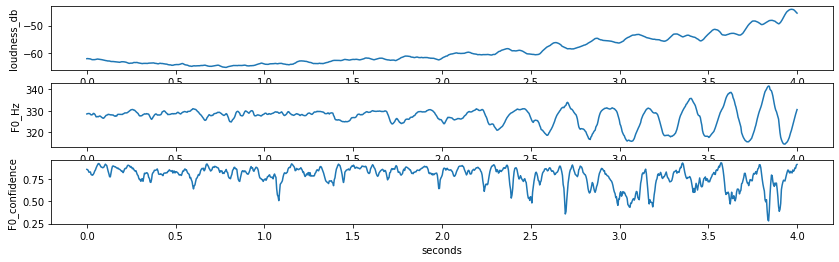

In [5]:
# from ddsp.colab import colab_utils
import ddsp.training
from matplotlib import pyplot as plt
import numpy as np

data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)

try:
  ex = next(iter(dataset))
except StopIteration:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')


f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')
ax[1].plot(x, ex['f0_hz'])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'])


## Train Model

We will now train a "solo instrument" model. This means the model is conditioned only on the fundamental frequency (f0) and loudness with no instrument ID or latent timbre feature. If you uploaded audio of multiple instruemnts, the neural network you train will attempt to model all timbres, but will likely associate certain timbres with different f0 and loudness conditions. 

First, let's start up a [TensorBoard](https://www.tensorflow.org/tensorboard) to monitor our loss as training proceeds. 

Initially, TensorBoard will report `No dashboards are active for the current data set.`, but once training begins, the dashboards should appear.

In [20]:
%reload_ext tensorboard
import tensorboard as tb
tb.notebook.start('--logdir "{}"'.format(SAVE_DIR))

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

### We will now begin training. 

Note that we specify [gin configuration](https://github.com/google/gin-config) files for the both the model architecture ([solo_instrument.gin](TODO)) and the dataset ([tfrecord.gin](TODO)), which are both predefined in the library. You could also create your own. We then override some of the spefic params for `batch_size` (which is defined in in the model gin file) and the tfrecord path (which is defined in the dataset file). 

### Training Notes:
* Models typically perform well when the loss drops to the range of ~4.5-5.0.
* Depending on the dataset this can take anywhere from 5k-30k training steps usually.
* The default is set to 30k, but you can stop training at any time, and for timbre transfer, it's best to stop before the loss drops too far below ~5.0 to avoid overfitting.
* On the colab GPU, this can take from around 3-20 hours. 
* We **highly recommend** saving checkpoints directly to your drive account as colab will restart naturally after about 12 hours and you may lose all of your checkpoints.
* By default, checkpoints will be saved every 300 steps with a maximum of 10 checkpoints (at ~60MB/checkpoint this is ~600MB). Feel free to adjust these numbers depending on the frequency of saves you would like and space on your drive.
* If you're restarting a session and `DRIVE_DIR` points a directory that was previously used for training, training should resume at the last checkpoint.

In [34]:
TRAIN_TFRECORD_FILEPATTERN = "/home/teo/userdata/datasets/datasets-master/train.tfrecord*"

In [7]:
from ddsp.training import (data, decoders, encoders, models, preprocessing, 
                           train_util, trainers)

sample_rate = 16000
TIME_STEPS = 1000

dataset = data_provider.get_batch(batch_size=32, shuffle=False)
batch = next(iter(dataset))
audio = batch['audio']
n_samples = audio.shape[1]

strategy = train_util.get_strategy()
# Create Neural Networks.
preprocessor = preprocessing.F0LoudnessPreprocessor(time_steps=TIME_STEPS)

decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                rnn_type = 'gru',
                                ch = 256,
                                layers_per_stack = 1,
                                input_keys = ('ld_scaled', 'f0_scaled'),
                                output_splits = (('amps', 1),
                                                 ('harmonic_distribution', 45),
                                                 ('noise_magnitudes', 45)))

# Create Processors.
harmonic = ddsp.synths.Harmonic(n_samples=n_samples, 
                                sample_rate=sample_rate,
                                name='harmonic')

noise = ddsp.synths.FilteredNoise(window_size=0,
                                  initial_bias=-10.0,
                                  name='noise')
add = ddsp.processors.Add(name='add')

# Create ProcessorGroup.
dag = [(harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
       (noise, ['noise_magnitudes']),
       (add, ['noise/signal', 'harmonic/signal'])]

processor_group = ddsp.processors.ProcessorGroup(dag=dag,
                                                 name='processor_group')


# Loss_functions
spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                         mag_weight=1.0,
                                         logmag_weight=1.0)

with strategy.scope():
  # Put it together in a model.
  model = models.Autoencoder(preprocessor=preprocessor,
                             encoder=None,
                             decoder=decoder,
                             processor_group=processor_group,
                             losses=[spectral_loss])
  trainer = trainers.Trainer(model, strategy, learning_rate=1e-3)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
dataset = trainer.distribute_dataset(dataset)
trainer.build(next(iter(dataset)))

2021-11-15 12:04:59.699601: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-11-15 12:05:00.156140: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 f0_loudness_preprocessor (F  multiple                 0         
 0LoudnessPreprocessor)                                          
                                                                 
 rnn_fc_decoder (RnnFcDecode  multiple                 814171    
 r)                                                              
                                                                 
 processor_group (ProcessorG  multiple                 0         
 roup)                                                           
                                                                 
 spectral_loss (SpectralLoss  multiple                 0         
 )                                                               
                                                                 
Total params: 814,171
Trainable params: 814,171
Non-tra

In [9]:
dataset_iter = iter(dataset)

for i in range(10000):
  losses = trainer.train_step(dataset_iter)
  res_str = 'step: {}\t'.format(i)
  for k, v in losses.items():
    res_str += '{}: {:.2f}\t'.format(k, v)
  print(res_str)

step: 0	spectral_loss: 25.33	total_loss: 25.33	
step: 1	spectral_loss: 41.90	total_loss: 41.90	
step: 2	spectral_loss: 39.15	total_loss: 39.15	
step: 3	spectral_loss: 23.30	total_loss: 23.30	
step: 4	spectral_loss: 14.43	total_loss: 14.43	
step: 5	spectral_loss: 14.95	total_loss: 14.95	
step: 6	spectral_loss: 14.79	total_loss: 14.79	
step: 7	spectral_loss: 15.01	total_loss: 15.01	
step: 8	spectral_loss: 13.64	total_loss: 13.64	
step: 9	spectral_loss: 14.64	total_loss: 14.64	
step: 10	spectral_loss: 13.86	total_loss: 13.86	
step: 11	spectral_loss: 15.91	total_loss: 15.91	
step: 12	spectral_loss: 13.80	total_loss: 13.80	
step: 13	spectral_loss: 13.18	total_loss: 13.18	
step: 14	spectral_loss: 14.59	total_loss: 14.59	
step: 15	spectral_loss: 15.17	total_loss: 15.17	
step: 16	spectral_loss: 14.48	total_loss: 14.48	
step: 17	spectral_loss: 14.25	total_loss: 14.25	
step: 18	spectral_loss: 14.67	total_loss: 14.67	
step: 19	spectral_loss: 14.35	total_loss: 14.35	
step: 20	spectral_loss: 13.90	

step: 167	spectral_loss: 7.64	total_loss: 7.64	
step: 168	spectral_loss: 11.61	total_loss: 11.61	
step: 169	spectral_loss: 11.46	total_loss: 11.46	
step: 170	spectral_loss: 10.99	total_loss: 10.99	
step: 171	spectral_loss: 10.43	total_loss: 10.43	
step: 172	spectral_loss: 10.40	total_loss: 10.40	
step: 173	spectral_loss: 12.45	total_loss: 12.45	
step: 174	spectral_loss: 11.13	total_loss: 11.13	
step: 175	spectral_loss: 11.82	total_loss: 11.82	
step: 176	spectral_loss: 11.57	total_loss: 11.57	
step: 177	spectral_loss: 10.47	total_loss: 10.47	
step: 178	spectral_loss: 12.28	total_loss: 12.28	
step: 179	spectral_loss: 11.46	total_loss: 11.46	
step: 180	spectral_loss: 10.65	total_loss: 10.65	
step: 181	spectral_loss: 11.58	total_loss: 11.58	
step: 182	spectral_loss: 12.70	total_loss: 12.70	
step: 183	spectral_loss: 11.91	total_loss: 11.91	
step: 184	spectral_loss: 12.11	total_loss: 12.11	
step: 185	spectral_loss: 12.60	total_loss: 12.60	
step: 186	spectral_loss: 11.30	total_loss: 11.30	
st

step: 333	spectral_loss: 11.31	total_loss: 11.31	
step: 334	spectral_loss: 5.38	total_loss: 5.38	
step: 335	spectral_loss: 9.22	total_loss: 9.22	
step: 336	spectral_loss: 10.17	total_loss: 10.17	
step: 337	spectral_loss: 9.94	total_loss: 9.94	
step: 338	spectral_loss: 9.74	total_loss: 9.74	
step: 339	spectral_loss: 8.83	total_loss: 8.83	
step: 340	spectral_loss: 10.68	total_loss: 10.68	
step: 341	spectral_loss: 9.67	total_loss: 9.67	
step: 342	spectral_loss: 10.76	total_loss: 10.76	
step: 343	spectral_loss: 9.64	total_loss: 9.64	
step: 344	spectral_loss: 9.60	total_loss: 9.60	
step: 345	spectral_loss: 9.82	total_loss: 9.82	
step: 346	spectral_loss: 10.51	total_loss: 10.51	
step: 347	spectral_loss: 9.62	total_loss: 9.62	
step: 348	spectral_loss: 9.56	total_loss: 9.56	
step: 349	spectral_loss: 10.91	total_loss: 10.91	
step: 350	spectral_loss: 10.29	total_loss: 10.29	
step: 351	spectral_loss: 10.69	total_loss: 10.69	
step: 352	spectral_loss: 10.95	total_loss: 10.95	
step: 353	spectral_los

step: 503	spectral_loss: 8.63	total_loss: 8.63	
step: 504	spectral_loss: 8.42	total_loss: 8.42	
step: 505	spectral_loss: 8.50	total_loss: 8.50	
step: 506	spectral_loss: 7.76	total_loss: 7.76	
step: 507	spectral_loss: 8.29	total_loss: 8.29	
step: 508	spectral_loss: 9.08	total_loss: 9.08	
step: 509	spectral_loss: 8.94	total_loss: 8.94	
step: 510	spectral_loss: 8.35	total_loss: 8.35	
step: 511	spectral_loss: 8.93	total_loss: 8.93	
step: 512	spectral_loss: 7.87	total_loss: 7.87	
step: 513	spectral_loss: 9.58	total_loss: 9.58	
step: 514	spectral_loss: 8.50	total_loss: 8.50	
step: 515	spectral_loss: 7.93	total_loss: 7.93	
step: 516	spectral_loss: 9.63	total_loss: 9.63	
step: 517	spectral_loss: 9.21	total_loss: 9.21	
step: 518	spectral_loss: 9.42	total_loss: 9.42	
step: 519	spectral_loss: 9.30	total_loss: 9.30	
step: 520	spectral_loss: 9.78	total_loss: 9.78	
step: 521	spectral_loss: 9.30	total_loss: 9.30	
step: 522	spectral_loss: 8.59	total_loss: 8.59	
step: 523	spectral_loss: 7.79	total_loss

step: 674	spectral_loss: 7.32	total_loss: 7.32	
step: 675	spectral_loss: 9.48	total_loss: 9.48	
step: 676	spectral_loss: 8.10	total_loss: 8.10	
step: 677	spectral_loss: 8.64	total_loss: 8.64	
step: 678	spectral_loss: 8.57	total_loss: 8.57	
step: 679	spectral_loss: 7.58	total_loss: 7.58	
step: 680	spectral_loss: 9.06	total_loss: 9.06	
step: 681	spectral_loss: 8.23	total_loss: 8.23	
step: 682	spectral_loss: 7.77	total_loss: 7.77	
step: 683	spectral_loss: 8.51	total_loss: 8.51	
step: 684	spectral_loss: 9.17	total_loss: 9.17	
step: 685	spectral_loss: 8.51	total_loss: 8.51	
step: 686	spectral_loss: 8.86	total_loss: 8.86	
step: 687	spectral_loss: 9.19	total_loss: 9.19	
step: 688	spectral_loss: 8.00	total_loss: 8.00	
step: 689	spectral_loss: 9.04	total_loss: 9.04	
step: 690	spectral_loss: 7.55	total_loss: 7.55	
step: 691	spectral_loss: 8.56	total_loss: 8.56	
step: 692	spectral_loss: 8.00	total_loss: 8.00	
step: 693	spectral_loss: 5.40	total_loss: 5.40	
step: 694	spectral_loss: 7.93	total_loss

step: 845	spectral_loss: 7.84	total_loss: 7.84	
step: 846	spectral_loss: 8.17	total_loss: 8.17	
step: 847	spectral_loss: 8.11	total_loss: 8.11	
step: 848	spectral_loss: 8.65	total_loss: 8.65	
step: 849	spectral_loss: 7.86	total_loss: 7.86	
step: 850	spectral_loss: 8.04	total_loss: 8.04	
step: 851	spectral_loss: 9.35	total_loss: 9.35	
step: 852	spectral_loss: 8.37	total_loss: 8.37	
step: 853	spectral_loss: 8.68	total_loss: 8.68	
step: 854	spectral_loss: 8.88	total_loss: 8.88	
step: 855	spectral_loss: 8.20	total_loss: 8.20	
step: 856	spectral_loss: 8.68	total_loss: 8.68	
step: 857	spectral_loss: 7.29	total_loss: 7.29	
step: 858	spectral_loss: 7.92	total_loss: 7.92	
step: 859	spectral_loss: 9.46	total_loss: 9.46	
step: 860	spectral_loss: 4.26	total_loss: 4.26	
step: 861	spectral_loss: 7.28	total_loss: 7.28	
step: 862	spectral_loss: 8.13	total_loss: 8.13	
step: 863	spectral_loss: 7.83	total_loss: 7.83	
step: 864	spectral_loss: 7.28	total_loss: 7.28	
step: 865	spectral_loss: 6.97	total_loss

step: 1016	spectral_loss: 7.44	total_loss: 7.44	
step: 1017	spectral_loss: 6.99	total_loss: 6.99	
step: 1018	spectral_loss: 8.61	total_loss: 8.61	
step: 1019	spectral_loss: 8.36	total_loss: 8.36	
step: 1020	spectral_loss: 8.56	total_loss: 8.56	
step: 1021	spectral_loss: 8.16	total_loss: 8.16	
step: 1022	spectral_loss: 8.31	total_loss: 8.31	
step: 1023	spectral_loss: 7.99	total_loss: 7.99	
step: 1024	spectral_loss: 7.80	total_loss: 7.80	
step: 1025	spectral_loss: 6.92	total_loss: 6.92	
step: 1026	spectral_loss: 8.60	total_loss: 8.60	
step: 1027	spectral_loss: 4.41	total_loss: 4.41	
step: 1028	spectral_loss: 7.31	total_loss: 7.31	
step: 1029	spectral_loss: 7.54	total_loss: 7.54	
step: 1030	spectral_loss: 7.18	total_loss: 7.18	
step: 1031	spectral_loss: 7.19	total_loss: 7.19	
step: 1032	spectral_loss: 6.71	total_loss: 6.71	
step: 1033	spectral_loss: 7.44	total_loss: 7.44	
step: 1034	spectral_loss: 7.80	total_loss: 7.80	
step: 1035	spectral_loss: 7.89	total_loss: 7.89	
step: 1036	spectral_

step: 1184	spectral_loss: 6.62	total_loss: 6.62	
step: 1185	spectral_loss: 7.33	total_loss: 7.33	
step: 1186	spectral_loss: 8.04	total_loss: 8.04	
step: 1187	spectral_loss: 7.07	total_loss: 7.07	
step: 1188	spectral_loss: 7.45	total_loss: 7.45	
step: 1189	spectral_loss: 7.73	total_loss: 7.73	
step: 1190	spectral_loss: 6.85	total_loss: 6.85	
step: 1191	spectral_loss: 7.67	total_loss: 7.67	
step: 1192	spectral_loss: 6.23	total_loss: 6.23	
step: 1193	spectral_loss: 6.98	total_loss: 6.98	
step: 1194	spectral_loss: 6.88	total_loss: 6.88	
step: 1195	spectral_loss: 4.45	total_loss: 4.45	
step: 1196	spectral_loss: 6.41	total_loss: 6.41	
step: 1197	spectral_loss: 6.68	total_loss: 6.68	
step: 1198	spectral_loss: 6.69	total_loss: 6.69	
step: 1199	spectral_loss: 6.25	total_loss: 6.25	
step: 1200	spectral_loss: 6.36	total_loss: 6.36	
step: 1201	spectral_loss: 7.63	total_loss: 7.63	
step: 1202	spectral_loss: 6.66	total_loss: 6.66	
step: 1203	spectral_loss: 7.06	total_loss: 7.06	
step: 1204	spectral_

step: 1352	spectral_loss: 6.73	total_loss: 6.73	
step: 1353	spectral_loss: 7.82	total_loss: 7.82	
step: 1354	spectral_loss: 6.93	total_loss: 6.93	
step: 1355	spectral_loss: 7.31	total_loss: 7.31	
step: 1356	spectral_loss: 7.65	total_loss: 7.65	
step: 1357	spectral_loss: 6.95	total_loss: 6.95	
step: 1358	spectral_loss: 7.43	total_loss: 7.43	
step: 1359	spectral_loss: 6.05	total_loss: 6.05	
step: 1360	spectral_loss: 6.21	total_loss: 6.21	
step: 1361	spectral_loss: 8.19	total_loss: 8.19	
step: 1362	spectral_loss: 3.59	total_loss: 3.59	
step: 1363	spectral_loss: 5.90	total_loss: 5.90	
step: 1364	spectral_loss: 6.58	total_loss: 6.58	
step: 1365	spectral_loss: 6.55	total_loss: 6.55	
step: 1366	spectral_loss: 6.06	total_loss: 6.06	
step: 1367	spectral_loss: 5.96	total_loss: 5.96	
step: 1368	spectral_loss: 7.17	total_loss: 7.17	
step: 1369	spectral_loss: 6.28	total_loss: 6.28	
step: 1370	spectral_loss: 7.23	total_loss: 7.23	
step: 1371	spectral_loss: 6.41	total_loss: 6.41	
step: 1372	spectral_

step: 1520	spectral_loss: 7.51	total_loss: 7.51	
step: 1521	spectral_loss: 7.14	total_loss: 7.14	
step: 1522	spectral_loss: 7.20	total_loss: 7.20	
step: 1523	spectral_loss: 7.13	total_loss: 7.13	
step: 1524	spectral_loss: 7.61	total_loss: 7.61	
step: 1525	spectral_loss: 7.00	total_loss: 7.00	
step: 1526	spectral_loss: 6.74	total_loss: 6.74	
step: 1527	spectral_loss: 6.01	total_loss: 6.01	
step: 1528	spectral_loss: 7.65	total_loss: 7.65	
step: 1529	spectral_loss: 4.06	total_loss: 4.06	
step: 1530	spectral_loss: 6.08	total_loss: 6.08	
step: 1531	spectral_loss: 6.31	total_loss: 6.31	
step: 1532	spectral_loss: 6.29	total_loss: 6.29	
step: 1533	spectral_loss: 6.42	total_loss: 6.42	
step: 1534	spectral_loss: 5.90	total_loss: 5.90	
step: 1535	spectral_loss: 6.52	total_loss: 6.52	
step: 1536	spectral_loss: 6.83	total_loss: 6.83	
step: 1537	spectral_loss: 6.86	total_loss: 6.86	
step: 1538	spectral_loss: 6.18	total_loss: 6.18	
step: 1539	spectral_loss: 6.95	total_loss: 6.95	
step: 1540	spectral_

step: 1688	spectral_loss: 7.51	total_loss: 7.51	
step: 1689	spectral_loss: 6.64	total_loss: 6.64	
step: 1690	spectral_loss: 7.10	total_loss: 7.10	
step: 1691	spectral_loss: 7.36	total_loss: 7.36	
step: 1692	spectral_loss: 6.48	total_loss: 6.48	
step: 1693	spectral_loss: 7.06	total_loss: 7.06	
step: 1694	spectral_loss: 5.98	total_loss: 5.98	
step: 1695	spectral_loss: 6.50	total_loss: 6.50	
step: 1696	spectral_loss: 6.62	total_loss: 6.62	
step: 1697	spectral_loss: 4.00	total_loss: 4.00	
step: 1698	spectral_loss: 6.14	total_loss: 6.14	
step: 1699	spectral_loss: 6.31	total_loss: 6.31	
step: 1700	spectral_loss: 6.37	total_loss: 6.37	
step: 1701	spectral_loss: 5.81	total_loss: 5.81	
step: 1702	spectral_loss: 5.83	total_loss: 5.83	
step: 1703	spectral_loss: 7.31	total_loss: 7.31	
step: 1704	spectral_loss: 6.52	total_loss: 6.52	
step: 1705	spectral_loss: 7.31	total_loss: 7.31	
step: 1706	spectral_loss: 7.21	total_loss: 7.21	
step: 1707	spectral_loss: 5.97	total_loss: 5.97	
step: 1708	spectral_

step: 1856	spectral_loss: 6.75	total_loss: 6.75	
step: 1857	spectral_loss: 7.06	total_loss: 7.06	
step: 1858	spectral_loss: 7.24	total_loss: 7.24	
step: 1859	spectral_loss: 6.85	total_loss: 6.85	
step: 1860	spectral_loss: 7.32	total_loss: 7.32	
step: 1861	spectral_loss: 6.03	total_loss: 6.03	
step: 1862	spectral_loss: 6.02	total_loss: 6.02	
step: 1863	spectral_loss: 8.00	total_loss: 8.00	
step: 1864	spectral_loss: 3.35	total_loss: 3.35	
step: 1865	spectral_loss: 5.91	total_loss: 5.91	
step: 1866	spectral_loss: 6.53	total_loss: 6.53	
step: 1867	spectral_loss: 6.25	total_loss: 6.25	
step: 1868	spectral_loss: 6.02	total_loss: 6.02	
step: 1869	spectral_loss: 5.96	total_loss: 5.96	
step: 1870	spectral_loss: 7.26	total_loss: 7.26	
step: 1871	spectral_loss: 6.30	total_loss: 6.30	
step: 1872	spectral_loss: 7.02	total_loss: 7.02	
step: 1873	spectral_loss: 6.12	total_loss: 6.12	
step: 1874	spectral_loss: 6.47	total_loss: 6.47	
step: 1875	spectral_loss: 6.68	total_loss: 6.68	
step: 1876	spectral_

step: 2024	spectral_loss: 6.92	total_loss: 6.92	
step: 2025	spectral_loss: 6.92	total_loss: 6.92	
step: 2026	spectral_loss: 7.25	total_loss: 7.25	
step: 2027	spectral_loss: 6.65	total_loss: 6.65	
step: 2028	spectral_loss: 6.57	total_loss: 6.57	
step: 2029	spectral_loss: 5.92	total_loss: 5.92	
step: 2030	spectral_loss: 7.23	total_loss: 7.23	
step: 2031	spectral_loss: 4.00	total_loss: 4.00	
step: 2032	spectral_loss: 5.81	total_loss: 5.81	
step: 2033	spectral_loss: 6.15	total_loss: 6.15	
step: 2034	spectral_loss: 6.02	total_loss: 6.02	
step: 2035	spectral_loss: 5.94	total_loss: 5.94	
step: 2036	spectral_loss: 5.65	total_loss: 5.65	
step: 2037	spectral_loss: 6.17	total_loss: 6.17	
step: 2038	spectral_loss: 6.73	total_loss: 6.73	
step: 2039	spectral_loss: 6.58	total_loss: 6.58	
step: 2040	spectral_loss: 6.06	total_loss: 6.06	
step: 2041	spectral_loss: 6.82	total_loss: 6.82	
step: 2042	spectral_loss: 5.82	total_loss: 5.82	
step: 2043	spectral_loss: 7.42	total_loss: 7.42	
step: 2044	spectral_

step: 2192	spectral_loss: 7.55	total_loss: 7.55	
step: 2193	spectral_loss: 7.78	total_loss: 7.78	
step: 2194	spectral_loss: 6.63	total_loss: 6.63	
step: 2195	spectral_loss: 7.25	total_loss: 7.25	
step: 2196	spectral_loss: 5.93	total_loss: 5.93	
step: 2197	spectral_loss: 6.59	total_loss: 6.59	
step: 2198	spectral_loss: 6.97	total_loss: 6.97	
step: 2199	spectral_loss: 3.82	total_loss: 3.82	
step: 2200	spectral_loss: 6.07	total_loss: 6.07	
step: 2201	spectral_loss: 6.34	total_loss: 6.34	
step: 2202	spectral_loss: 6.42	total_loss: 6.42	
step: 2203	spectral_loss: 5.76	total_loss: 5.76	
step: 2204	spectral_loss: 5.82	total_loss: 5.82	
step: 2205	spectral_loss: 7.33	total_loss: 7.33	
step: 2206	spectral_loss: 6.12	total_loss: 6.12	
step: 2207	spectral_loss: 6.66	total_loss: 6.66	
step: 2208	spectral_loss: 6.67	total_loss: 6.67	
step: 2209	spectral_loss: 5.84	total_loss: 5.84	
step: 2210	spectral_loss: 7.25	total_loss: 7.25	
step: 2211	spectral_loss: 6.48	total_loss: 6.48	
step: 2212	spectral_

step: 2360	spectral_loss: 6.99	total_loss: 6.99	
step: 2361	spectral_loss: 6.58	total_loss: 6.58	
step: 2362	spectral_loss: 7.00	total_loss: 7.00	
step: 2363	spectral_loss: 5.77	total_loss: 5.77	
step: 2364	spectral_loss: 5.93	total_loss: 5.93	
step: 2365	spectral_loss: 7.75	total_loss: 7.75	
step: 2366	spectral_loss: 3.22	total_loss: 3.22	
step: 2367	spectral_loss: 5.91	total_loss: 5.91	
step: 2368	spectral_loss: 6.35	total_loss: 6.35	
step: 2369	spectral_loss: 6.23	total_loss: 6.23	
step: 2370	spectral_loss: 5.87	total_loss: 5.87	
step: 2371	spectral_loss: 5.65	total_loss: 5.65	
step: 2372	spectral_loss: 6.85	total_loss: 6.85	
step: 2373	spectral_loss: 6.11	total_loss: 6.11	
step: 2374	spectral_loss: 6.84	total_loss: 6.84	
step: 2375	spectral_loss: 5.98	total_loss: 5.98	
step: 2376	spectral_loss: 6.29	total_loss: 6.29	
step: 2377	spectral_loss: 6.29	total_loss: 6.29	
step: 2378	spectral_loss: 6.97	total_loss: 6.97	
step: 2379	spectral_loss: 6.14	total_loss: 6.14	
step: 2380	spectral_

step: 2528	spectral_loss: 7.15	total_loss: 7.15	
step: 2529	spectral_loss: 6.52	total_loss: 6.52	
step: 2530	spectral_loss: 6.56	total_loss: 6.56	
step: 2531	spectral_loss: 5.83	total_loss: 5.83	
step: 2532	spectral_loss: 6.95	total_loss: 6.95	
step: 2533	spectral_loss: 4.17	total_loss: 4.17	
step: 2534	spectral_loss: 5.56	total_loss: 5.56	
step: 2535	spectral_loss: 6.04	total_loss: 6.04	
step: 2536	spectral_loss: 5.93	total_loss: 5.93	
step: 2537	spectral_loss: 5.89	total_loss: 5.89	
step: 2538	spectral_loss: 5.64	total_loss: 5.64	
step: 2539	spectral_loss: 6.15	total_loss: 6.15	
step: 2540	spectral_loss: 6.77	total_loss: 6.77	
step: 2541	spectral_loss: 6.45	total_loss: 6.45	
step: 2542	spectral_loss: 6.17	total_loss: 6.17	
step: 2543	spectral_loss: 6.68	total_loss: 6.68	
step: 2544	spectral_loss: 5.63	total_loss: 5.63	
step: 2545	spectral_loss: 7.33	total_loss: 7.33	
step: 2546	spectral_loss: 6.17	total_loss: 6.17	
step: 2547	spectral_loss: 6.07	total_loss: 6.07	
step: 2548	spectral_

step: 2696	spectral_loss: 6.26	total_loss: 6.26	
step: 2697	spectral_loss: 6.97	total_loss: 6.97	
step: 2698	spectral_loss: 5.68	total_loss: 5.68	
step: 2699	spectral_loss: 6.18	total_loss: 6.18	
step: 2700	spectral_loss: 6.88	total_loss: 6.88	
step: 2701	spectral_loss: 3.51	total_loss: 3.51	
step: 2702	spectral_loss: 5.78	total_loss: 5.78	
step: 2703	spectral_loss: 6.10	total_loss: 6.10	
step: 2704	spectral_loss: 6.19	total_loss: 6.19	
step: 2705	spectral_loss: 5.62	total_loss: 5.62	
step: 2706	spectral_loss: 5.77	total_loss: 5.77	
step: 2707	spectral_loss: 7.16	total_loss: 7.16	
step: 2708	spectral_loss: 5.84	total_loss: 5.84	
step: 2709	spectral_loss: 6.56	total_loss: 6.56	
step: 2710	spectral_loss: 6.43	total_loss: 6.43	
step: 2711	spectral_loss: 5.65	total_loss: 5.65	
step: 2712	spectral_loss: 7.12	total_loss: 7.12	
step: 2713	spectral_loss: 6.43	total_loss: 6.43	
step: 2714	spectral_loss: 6.12	total_loss: 6.12	
step: 2715	spectral_loss: 6.65	total_loss: 6.65	
step: 2716	spectral_

step: 2864	spectral_loss: 6.90	total_loss: 6.90	
step: 2865	spectral_loss: 5.71	total_loss: 5.71	
step: 2866	spectral_loss: 5.72	total_loss: 5.72	
step: 2867	spectral_loss: 7.58	total_loss: 7.58	
step: 2868	spectral_loss: 3.09	total_loss: 3.09	
step: 2869	spectral_loss: 5.57	total_loss: 5.57	
step: 2870	spectral_loss: 6.25	total_loss: 6.25	
step: 2871	spectral_loss: 5.95	total_loss: 5.95	
step: 2872	spectral_loss: 5.63	total_loss: 5.63	
step: 2873	spectral_loss: 5.54	total_loss: 5.54	
step: 2874	spectral_loss: 6.57	total_loss: 6.57	
step: 2875	spectral_loss: 5.92	total_loss: 5.92	
step: 2876	spectral_loss: 6.62	total_loss: 6.62	
step: 2877	spectral_loss: 5.80	total_loss: 5.80	
step: 2878	spectral_loss: 6.18	total_loss: 6.18	
step: 2879	spectral_loss: 5.97	total_loss: 5.97	
step: 2880	spectral_loss: 6.76	total_loss: 6.76	
step: 2881	spectral_loss: 5.96	total_loss: 5.96	
step: 2882	spectral_loss: 6.06	total_loss: 6.06	
step: 2883	spectral_loss: 7.11	total_loss: 7.11	
step: 2884	spectral_

step: 3032	spectral_loss: 6.46	total_loss: 6.46	
step: 3033	spectral_loss: 5.66	total_loss: 5.66	
step: 3034	spectral_loss: 6.77	total_loss: 6.77	
step: 3035	spectral_loss: 4.32	total_loss: 4.32	
step: 3036	spectral_loss: 5.21	total_loss: 5.21	
step: 3037	spectral_loss: 5.88	total_loss: 5.88	
step: 3038	spectral_loss: 5.96	total_loss: 5.96	
step: 3039	spectral_loss: 5.94	total_loss: 5.94	
step: 3040	spectral_loss: 5.57	total_loss: 5.57	
step: 3041	spectral_loss: 5.94	total_loss: 5.94	
step: 3042	spectral_loss: 6.65	total_loss: 6.65	
step: 3043	spectral_loss: 6.20	total_loss: 6.20	
step: 3044	spectral_loss: 5.97	total_loss: 5.97	
step: 3045	spectral_loss: 6.49	total_loss: 6.49	
step: 3046	spectral_loss: 5.37	total_loss: 5.37	
step: 3047	spectral_loss: 7.12	total_loss: 7.12	
step: 3048	spectral_loss: 6.00	total_loss: 6.00	
step: 3049	spectral_loss: 5.80	total_loss: 5.80	
step: 3050	spectral_loss: 7.00	total_loss: 7.00	
step: 3051	spectral_loss: 6.57	total_loss: 6.57	
step: 3052	spectral_

step: 3200	spectral_loss: 5.52	total_loss: 5.52	
step: 3201	spectral_loss: 6.00	total_loss: 6.00	
step: 3202	spectral_loss: 6.89	total_loss: 6.89	
step: 3203	spectral_loss: 3.23	total_loss: 3.23	
step: 3204	spectral_loss: 5.49	total_loss: 5.49	
step: 3205	spectral_loss: 5.92	total_loss: 5.92	
step: 3206	spectral_loss: 6.00	total_loss: 6.00	
step: 3207	spectral_loss: 5.46	total_loss: 5.46	
step: 3208	spectral_loss: 5.51	total_loss: 5.51	
step: 3209	spectral_loss: 6.85	total_loss: 6.85	
step: 3210	spectral_loss: 5.60	total_loss: 5.60	
step: 3211	spectral_loss: 6.40	total_loss: 6.40	
step: 3212	spectral_loss: 6.18	total_loss: 6.18	
step: 3213	spectral_loss: 5.47	total_loss: 5.47	
step: 3214	spectral_loss: 6.71	total_loss: 6.71	
step: 3215	spectral_loss: 6.13	total_loss: 6.13	
step: 3216	spectral_loss: 5.86	total_loss: 5.86	
step: 3217	spectral_loss: 6.34	total_loss: 6.34	
step: 3218	spectral_loss: 6.99	total_loss: 6.99	
step: 3219	spectral_loss: 6.22	total_loss: 6.22	
step: 3220	spectral_

step: 3368	spectral_loss: 5.59	total_loss: 5.59	
step: 3369	spectral_loss: 7.31	total_loss: 7.31	
step: 3370	spectral_loss: 3.09	total_loss: 3.09	
step: 3371	spectral_loss: 5.49	total_loss: 5.49	
step: 3372	spectral_loss: 6.07	total_loss: 6.07	
step: 3373	spectral_loss: 5.91	total_loss: 5.91	
step: 3374	spectral_loss: 5.62	total_loss: 5.62	
step: 3375	spectral_loss: 5.38	total_loss: 5.38	
step: 3376	spectral_loss: 6.44	total_loss: 6.44	
step: 3377	spectral_loss: 5.90	total_loss: 5.90	
step: 3378	spectral_loss: 6.63	total_loss: 6.63	
step: 3379	spectral_loss: 5.69	total_loss: 5.69	
step: 3380	spectral_loss: 6.17	total_loss: 6.17	
step: 3381	spectral_loss: 5.87	total_loss: 5.87	
step: 3382	spectral_loss: 6.65	total_loss: 6.65	
step: 3383	spectral_loss: 5.89	total_loss: 5.89	
step: 3384	spectral_loss: 6.00	total_loss: 6.00	
step: 3385	spectral_loss: 7.03	total_loss: 7.03	
step: 3386	spectral_loss: 6.22	total_loss: 6.22	
step: 3387	spectral_loss: 6.58	total_loss: 6.58	
step: 3388	spectral_

step: 3536	spectral_loss: 6.73	total_loss: 6.73	
step: 3537	spectral_loss: 4.54	total_loss: 4.54	
step: 3538	spectral_loss: 5.07	total_loss: 5.07	
step: 3539	spectral_loss: 5.86	total_loss: 5.86	
step: 3540	spectral_loss: 6.02	total_loss: 6.02	
step: 3541	spectral_loss: 5.88	total_loss: 5.88	
step: 3542	spectral_loss: 5.46	total_loss: 5.46	
step: 3543	spectral_loss: 5.80	total_loss: 5.80	
step: 3544	spectral_loss: 6.64	total_loss: 6.64	
step: 3545	spectral_loss: 6.04	total_loss: 6.04	
step: 3546	spectral_loss: 5.95	total_loss: 5.95	
step: 3547	spectral_loss: 6.44	total_loss: 6.44	
step: 3548	spectral_loss: 5.26	total_loss: 5.26	
step: 3549	spectral_loss: 6.99	total_loss: 6.99	
step: 3550	spectral_loss: 6.00	total_loss: 6.00	
step: 3551	spectral_loss: 5.80	total_loss: 5.80	
step: 3552	spectral_loss: 6.96	total_loss: 6.96	
step: 3553	spectral_loss: 6.66	total_loss: 6.66	
step: 3554	spectral_loss: 6.59	total_loss: 6.59	
step: 3555	spectral_loss: 6.59	total_loss: 6.59	
step: 3556	spectral_

step: 3704	spectral_loss: 7.07	total_loss: 7.07	
step: 3705	spectral_loss: 3.05	total_loss: 3.05	
step: 3706	spectral_loss: 5.52	total_loss: 5.52	
step: 3707	spectral_loss: 5.83	total_loss: 5.83	
step: 3708	spectral_loss: 5.97	total_loss: 5.97	
step: 3709	spectral_loss: 5.38	total_loss: 5.38	
step: 3710	spectral_loss: 5.41	total_loss: 5.41	
step: 3711	spectral_loss: 6.82	total_loss: 6.82	
step: 3712	spectral_loss: 5.62	total_loss: 5.62	
step: 3713	spectral_loss: 6.49	total_loss: 6.49	
step: 3714	spectral_loss: 6.11	total_loss: 6.11	
step: 3715	spectral_loss: 5.56	total_loss: 5.56	
step: 3716	spectral_loss: 6.63	total_loss: 6.63	
step: 3717	spectral_loss: 6.15	total_loss: 6.15	
step: 3718	spectral_loss: 5.80	total_loss: 5.80	
step: 3719	spectral_loss: 6.30	total_loss: 6.30	
step: 3720	spectral_loss: 7.02	total_loss: 7.02	
step: 3721	spectral_loss: 6.16	total_loss: 6.16	
step: 3722	spectral_loss: 6.62	total_loss: 6.62	
step: 3723	spectral_loss: 6.80	total_loss: 6.80	
step: 3724	spectral_

step: 3872	spectral_loss: 3.18	total_loss: 3.18	
step: 3873	spectral_loss: 5.60	total_loss: 5.60	
step: 3874	spectral_loss: 6.14	total_loss: 6.14	
step: 3875	spectral_loss: 5.85	total_loss: 5.85	
step: 3876	spectral_loss: 5.62	total_loss: 5.62	
step: 3877	spectral_loss: 5.39	total_loss: 5.39	
step: 3878	spectral_loss: 6.56	total_loss: 6.56	
step: 3879	spectral_loss: 6.13	total_loss: 6.13	
step: 3880	spectral_loss: 6.90	total_loss: 6.90	
step: 3881	spectral_loss: 5.84	total_loss: 5.84	
step: 3882	spectral_loss: 6.28	total_loss: 6.28	
step: 3883	spectral_loss: 5.82	total_loss: 5.82	
step: 3884	spectral_loss: 6.79	total_loss: 6.79	
step: 3885	spectral_loss: 5.89	total_loss: 5.89	
step: 3886	spectral_loss: 6.04	total_loss: 6.04	
step: 3887	spectral_loss: 6.99	total_loss: 6.99	
step: 3888	spectral_loss: 6.31	total_loss: 6.31	
step: 3889	spectral_loss: 6.70	total_loss: 6.70	
step: 3890	spectral_loss: 6.89	total_loss: 6.89	
step: 3891	spectral_loss: 6.33	total_loss: 6.33	
step: 3892	spectral_

step: 4040	spectral_loss: 4.77	total_loss: 4.77	
step: 4041	spectral_loss: 5.67	total_loss: 5.67	
step: 4042	spectral_loss: 5.82	total_loss: 5.82	
step: 4043	spectral_loss: 5.91	total_loss: 5.91	
step: 4044	spectral_loss: 5.49	total_loss: 5.49	
step: 4045	spectral_loss: 5.72	total_loss: 5.72	
step: 4046	spectral_loss: 6.67	total_loss: 6.67	
step: 4047	spectral_loss: 6.00	total_loss: 6.00	
step: 4048	spectral_loss: 5.92	total_loss: 5.92	
step: 4049	spectral_loss: 6.46	total_loss: 6.46	
step: 4050	spectral_loss: 5.28	total_loss: 5.28	
step: 4051	spectral_loss: 6.91	total_loss: 6.91	
step: 4052	spectral_loss: 5.91	total_loss: 5.91	
step: 4053	spectral_loss: 5.66	total_loss: 5.66	
step: 4054	spectral_loss: 6.90	total_loss: 6.90	
step: 4055	spectral_loss: 6.71	total_loss: 6.71	
step: 4056	spectral_loss: 6.49	total_loss: 6.49	
step: 4057	spectral_loss: 6.53	total_loss: 6.53	
step: 4058	spectral_loss: 6.81	total_loss: 6.81	
step: 4059	spectral_loss: 6.16	total_loss: 6.16	
step: 4060	spectral_

step: 4208	spectral_loss: 5.44	total_loss: 5.44	
step: 4209	spectral_loss: 5.91	total_loss: 5.91	
step: 4210	spectral_loss: 6.24	total_loss: 6.24	
step: 4211	spectral_loss: 5.54	total_loss: 5.54	
step: 4212	spectral_loss: 5.47	total_loss: 5.47	
step: 4213	spectral_loss: 6.87	total_loss: 6.87	
step: 4214	spectral_loss: 5.73	total_loss: 5.73	
step: 4215	spectral_loss: 6.54	total_loss: 6.54	
step: 4216	spectral_loss: 5.99	total_loss: 5.99	
step: 4217	spectral_loss: 5.64	total_loss: 5.64	
step: 4218	spectral_loss: 6.65	total_loss: 6.65	
step: 4219	spectral_loss: 6.33	total_loss: 6.33	
step: 4220	spectral_loss: 5.84	total_loss: 5.84	
step: 4221	spectral_loss: 6.22	total_loss: 6.22	
step: 4222	spectral_loss: 6.99	total_loss: 6.99	
step: 4223	spectral_loss: 6.25	total_loss: 6.25	
step: 4224	spectral_loss: 6.59	total_loss: 6.59	
step: 4225	spectral_loss: 6.77	total_loss: 6.77	
step: 4226	spectral_loss: 5.94	total_loss: 5.94	
step: 4227	spectral_loss: 6.65	total_loss: 6.65	
step: 4228	spectral_

step: 4376	spectral_loss: 5.94	total_loss: 5.94	
step: 4377	spectral_loss: 5.76	total_loss: 5.76	
step: 4378	spectral_loss: 5.63	total_loss: 5.63	
step: 4379	spectral_loss: 5.32	total_loss: 5.32	
step: 4380	spectral_loss: 6.27	total_loss: 6.27	
step: 4381	spectral_loss: 5.88	total_loss: 5.88	
step: 4382	spectral_loss: 6.47	total_loss: 6.47	
step: 4383	spectral_loss: 5.58	total_loss: 5.58	
step: 4384	spectral_loss: 6.22	total_loss: 6.22	
step: 4385	spectral_loss: 5.75	total_loss: 5.75	
step: 4386	spectral_loss: 6.70	total_loss: 6.70	
step: 4387	spectral_loss: 5.69	total_loss: 5.69	
step: 4388	spectral_loss: 5.88	total_loss: 5.88	
step: 4389	spectral_loss: 6.98	total_loss: 6.98	
step: 4390	spectral_loss: 6.24	total_loss: 6.24	
step: 4391	spectral_loss: 6.53	total_loss: 6.53	
step: 4392	spectral_loss: 6.62	total_loss: 6.62	
step: 4393	spectral_loss: 6.36	total_loss: 6.36	
step: 4394	spectral_loss: 6.65	total_loss: 6.65	
step: 4395	spectral_loss: 5.48	total_loss: 5.48	
step: 4396	spectral_

step: 4544	spectral_loss: 5.73	total_loss: 5.73	
step: 4545	spectral_loss: 5.68	total_loss: 5.68	
step: 4546	spectral_loss: 5.37	total_loss: 5.37	
step: 4547	spectral_loss: 5.63	total_loss: 5.63	
step: 4548	spectral_loss: 6.63	total_loss: 6.63	
step: 4549	spectral_loss: 5.91	total_loss: 5.91	
step: 4550	spectral_loss: 5.94	total_loss: 5.94	
step: 4551	spectral_loss: 6.32	total_loss: 6.32	
step: 4552	spectral_loss: 5.24	total_loss: 5.24	
step: 4553	spectral_loss: 6.88	total_loss: 6.88	
step: 4554	spectral_loss: 5.92	total_loss: 5.92	
step: 4555	spectral_loss: 5.77	total_loss: 5.77	
step: 4556	spectral_loss: 7.00	total_loss: 7.00	
step: 4557	spectral_loss: 6.77	total_loss: 6.77	
step: 4558	spectral_loss: 6.51	total_loss: 6.51	
step: 4559	spectral_loss: 6.50	total_loss: 6.50	
step: 4560	spectral_loss: 6.78	total_loss: 6.78	
step: 4561	spectral_loss: 6.07	total_loss: 6.07	
step: 4562	spectral_loss: 6.22	total_loss: 6.22	
step: 4563	spectral_loss: 5.51	total_loss: 5.51	
step: 4564	spectral_

step: 4712	spectral_loss: 6.01	total_loss: 6.01	
step: 4713	spectral_loss: 5.37	total_loss: 5.37	
step: 4714	spectral_loss: 5.50	total_loss: 5.50	
step: 4715	spectral_loss: 6.84	total_loss: 6.84	
step: 4716	spectral_loss: 5.59	total_loss: 5.59	
step: 4717	spectral_loss: 6.52	total_loss: 6.52	
step: 4718	spectral_loss: 5.91	total_loss: 5.91	
step: 4719	spectral_loss: 5.61	total_loss: 5.61	
step: 4720	spectral_loss: 6.42	total_loss: 6.42	
step: 4721	spectral_loss: 6.13	total_loss: 6.13	
step: 4722	spectral_loss: 5.78	total_loss: 5.78	
step: 4723	spectral_loss: 6.14	total_loss: 6.14	
step: 4724	spectral_loss: 6.94	total_loss: 6.94	
step: 4725	spectral_loss: 6.15	total_loss: 6.15	
step: 4726	spectral_loss: 6.53	total_loss: 6.53	
step: 4727	spectral_loss: 6.75	total_loss: 6.75	
step: 4728	spectral_loss: 5.85	total_loss: 5.85	
step: 4729	spectral_loss: 6.67	total_loss: 6.67	
step: 4730	spectral_loss: 5.40	total_loss: 5.40	
step: 4731	spectral_loss: 5.80	total_loss: 5.80	
step: 4732	spectral_

step: 4880	spectral_loss: 5.47	total_loss: 5.47	
step: 4881	spectral_loss: 5.30	total_loss: 5.30	
step: 4882	spectral_loss: 6.11	total_loss: 6.11	
step: 4883	spectral_loss: 5.89	total_loss: 5.89	
step: 4884	spectral_loss: 6.38	total_loss: 6.38	
step: 4885	spectral_loss: 5.54	total_loss: 5.54	
step: 4886	spectral_loss: 6.21	total_loss: 6.21	
step: 4887	spectral_loss: 5.62	total_loss: 5.62	
step: 4888	spectral_loss: 6.71	total_loss: 6.71	
step: 4889	spectral_loss: 5.73	total_loss: 5.73	
step: 4890	spectral_loss: 5.79	total_loss: 5.79	
step: 4891	spectral_loss: 6.90	total_loss: 6.90	
step: 4892	spectral_loss: 6.26	total_loss: 6.26	
step: 4893	spectral_loss: 6.44	total_loss: 6.44	
step: 4894	spectral_loss: 6.56	total_loss: 6.56	
step: 4895	spectral_loss: 6.32	total_loss: 6.32	
step: 4896	spectral_loss: 6.50	total_loss: 6.50	
step: 4897	spectral_loss: 5.46	total_loss: 5.46	
step: 4898	spectral_loss: 5.42	total_loss: 5.42	
step: 4899	spectral_loss: 7.14	total_loss: 7.14	
step: 4900	spectral_

step: 5048	spectral_loss: 5.43	total_loss: 5.43	
step: 5049	spectral_loss: 5.59	total_loss: 5.59	
step: 5050	spectral_loss: 6.68	total_loss: 6.68	
step: 5051	spectral_loss: 5.82	total_loss: 5.82	
step: 5052	spectral_loss: 6.00	total_loss: 6.00	
step: 5053	spectral_loss: 6.42	total_loss: 6.42	
step: 5054	spectral_loss: 5.26	total_loss: 5.26	
step: 5055	spectral_loss: 6.80	total_loss: 6.80	
step: 5056	spectral_loss: 5.88	total_loss: 5.88	
step: 5057	spectral_loss: 5.63	total_loss: 5.63	
step: 5058	spectral_loss: 6.66	total_loss: 6.66	
step: 5059	spectral_loss: 6.63	total_loss: 6.63	
step: 5060	spectral_loss: 6.23	total_loss: 6.23	
step: 5061	spectral_loss: 6.38	total_loss: 6.38	
step: 5062	spectral_loss: 6.74	total_loss: 6.74	
step: 5063	spectral_loss: 5.87	total_loss: 5.87	
step: 5064	spectral_loss: 6.20	total_loss: 6.20	
step: 5065	spectral_loss: 5.36	total_loss: 5.36	
step: 5066	spectral_loss: 6.39	total_loss: 6.39	
step: 5067	spectral_loss: 4.29	total_loss: 4.29	
step: 5068	spectral_

step: 5216	spectral_loss: 5.39	total_loss: 5.39	
step: 5217	spectral_loss: 6.58	total_loss: 6.58	
step: 5218	spectral_loss: 5.57	total_loss: 5.57	
step: 5219	spectral_loss: 6.42	total_loss: 6.42	
step: 5220	spectral_loss: 5.82	total_loss: 5.82	
step: 5221	spectral_loss: 5.57	total_loss: 5.57	
step: 5222	spectral_loss: 6.29	total_loss: 6.29	
step: 5223	spectral_loss: 6.21	total_loss: 6.21	
step: 5224	spectral_loss: 5.73	total_loss: 5.73	
step: 5225	spectral_loss: 6.01	total_loss: 6.01	
step: 5226	spectral_loss: 6.86	total_loss: 6.86	
step: 5227	spectral_loss: 6.05	total_loss: 6.05	
step: 5228	spectral_loss: 6.43	total_loss: 6.43	
step: 5229	spectral_loss: 6.63	total_loss: 6.63	
step: 5230	spectral_loss: 5.83	total_loss: 5.83	
step: 5231	spectral_loss: 6.56	total_loss: 6.56	
step: 5232	spectral_loss: 5.32	total_loss: 5.32	
step: 5233	spectral_loss: 5.71	total_loss: 5.71	
step: 5234	spectral_loss: 6.78	total_loss: 6.78	
step: 5235	spectral_loss: 2.97	total_loss: 2.97	
step: 5236	spectral_

step: 5384	spectral_loss: 6.18	total_loss: 6.18	
step: 5385	spectral_loss: 6.06	total_loss: 6.06	
step: 5386	spectral_loss: 6.29	total_loss: 6.29	
step: 5387	spectral_loss: 5.47	total_loss: 5.47	
step: 5388	spectral_loss: 6.32	total_loss: 6.32	
step: 5389	spectral_loss: 5.56	total_loss: 5.56	
step: 5390	spectral_loss: 6.68	total_loss: 6.68	
step: 5391	spectral_loss: 5.78	total_loss: 5.78	
step: 5392	spectral_loss: 5.81	total_loss: 5.81	
step: 5393	spectral_loss: 6.92	total_loss: 6.92	
step: 5394	spectral_loss: 6.25	total_loss: 6.25	
step: 5395	spectral_loss: 6.45	total_loss: 6.45	
step: 5396	spectral_loss: 6.54	total_loss: 6.54	
step: 5397	spectral_loss: 6.34	total_loss: 6.34	
step: 5398	spectral_loss: 6.47	total_loss: 6.47	
step: 5399	spectral_loss: 5.49	total_loss: 5.49	
step: 5400	spectral_loss: 5.37	total_loss: 5.37	
step: 5401	spectral_loss: 7.12	total_loss: 7.12	
step: 5402	spectral_loss: 3.03	total_loss: 3.03	
step: 5403	spectral_loss: 5.31	total_loss: 5.31	
step: 5404	spectral_

step: 5552	spectral_loss: 6.56	total_loss: 6.56	
step: 5553	spectral_loss: 5.73	total_loss: 5.73	
step: 5554	spectral_loss: 5.94	total_loss: 5.94	
step: 5555	spectral_loss: 6.25	total_loss: 6.25	
step: 5556	spectral_loss: 5.11	total_loss: 5.11	
step: 5557	spectral_loss: 6.74	total_loss: 6.74	
step: 5558	spectral_loss: 5.82	total_loss: 5.82	
step: 5559	spectral_loss: 5.53	total_loss: 5.53	
step: 5560	spectral_loss: 6.54	total_loss: 6.54	
step: 5561	spectral_loss: 6.59	total_loss: 6.59	
step: 5562	spectral_loss: 6.26	total_loss: 6.26	
step: 5563	spectral_loss: 6.34	total_loss: 6.34	
step: 5564	spectral_loss: 6.74	total_loss: 6.74	
step: 5565	spectral_loss: 5.81	total_loss: 5.81	
step: 5566	spectral_loss: 6.20	total_loss: 6.20	
step: 5567	spectral_loss: 5.34	total_loss: 5.34	
step: 5568	spectral_loss: 6.25	total_loss: 6.25	
step: 5569	spectral_loss: 4.54	total_loss: 4.54	
step: 5570	spectral_loss: 4.55	total_loss: 4.55	
step: 5571	spectral_loss: 5.47	total_loss: 5.47	
step: 5572	spectral_

step: 5720	spectral_loss: 5.61	total_loss: 5.61	
step: 5721	spectral_loss: 6.43	total_loss: 6.43	
step: 5722	spectral_loss: 5.77	total_loss: 5.77	
step: 5723	spectral_loss: 5.64	total_loss: 5.64	
step: 5724	spectral_loss: 6.18	total_loss: 6.18	
step: 5725	spectral_loss: 6.19	total_loss: 6.19	
step: 5726	spectral_loss: 5.66	total_loss: 5.66	
step: 5727	spectral_loss: 5.97	total_loss: 5.97	
step: 5728	spectral_loss: 6.79	total_loss: 6.79	
step: 5729	spectral_loss: 6.02	total_loss: 6.02	
step: 5730	spectral_loss: 6.39	total_loss: 6.39	
step: 5731	spectral_loss: 6.61	total_loss: 6.61	
step: 5732	spectral_loss: 5.85	total_loss: 5.85	
step: 5733	spectral_loss: 6.54	total_loss: 6.54	
step: 5734	spectral_loss: 5.28	total_loss: 5.28	
step: 5735	spectral_loss: 5.62	total_loss: 5.62	
step: 5736	spectral_loss: 6.85	total_loss: 6.85	
step: 5737	spectral_loss: 2.97	total_loss: 2.97	
step: 5738	spectral_loss: 5.28	total_loss: 5.28	
step: 5739	spectral_loss: 5.73	total_loss: 5.73	
step: 5740	spectral_

step: 5888	spectral_loss: 6.16	total_loss: 6.16	
step: 5889	spectral_loss: 5.48	total_loss: 5.48	
step: 5890	spectral_loss: 6.22	total_loss: 6.22	
step: 5891	spectral_loss: 5.42	total_loss: 5.42	
step: 5892	spectral_loss: 6.62	total_loss: 6.62	
step: 5893	spectral_loss: 5.64	total_loss: 5.64	
step: 5894	spectral_loss: 5.66	total_loss: 5.66	
step: 5895	spectral_loss: 6.86	total_loss: 6.86	
step: 5896	spectral_loss: 6.21	total_loss: 6.21	
step: 5897	spectral_loss: 6.40	total_loss: 6.40	
step: 5898	spectral_loss: 6.39	total_loss: 6.39	
step: 5899	spectral_loss: 6.27	total_loss: 6.27	
step: 5900	spectral_loss: 6.38	total_loss: 6.38	
step: 5901	spectral_loss: 5.50	total_loss: 5.50	
step: 5902	spectral_loss: 5.35	total_loss: 5.35	
step: 5903	spectral_loss: 6.97	total_loss: 6.97	
step: 5904	spectral_loss: 3.06	total_loss: 3.06	
step: 5905	spectral_loss: 5.33	total_loss: 5.33	
step: 5906	spectral_loss: 5.82	total_loss: 5.82	
step: 5907	spectral_loss: 5.59	total_loss: 5.59	
step: 5908	spectral_

step: 6056	spectral_loss: 6.04	total_loss: 6.04	
step: 6057	spectral_loss: 6.40	total_loss: 6.40	
step: 6058	spectral_loss: 5.16	total_loss: 5.16	
step: 6059	spectral_loss: 6.70	total_loss: 6.70	
step: 6060	spectral_loss: 5.88	total_loss: 5.88	
step: 6061	spectral_loss: 5.54	total_loss: 5.54	
step: 6062	spectral_loss: 6.47	total_loss: 6.47	
step: 6063	spectral_loss: 6.66	total_loss: 6.66	
step: 6064	spectral_loss: 6.19	total_loss: 6.19	
step: 6065	spectral_loss: 6.35	total_loss: 6.35	
step: 6066	spectral_loss: 6.65	total_loss: 6.65	
step: 6067	spectral_loss: 5.71	total_loss: 5.71	
step: 6068	spectral_loss: 6.24	total_loss: 6.24	
step: 6069	spectral_loss: 5.34	total_loss: 5.34	
step: 6070	spectral_loss: 6.14	total_loss: 6.14	
step: 6071	spectral_loss: 4.74	total_loss: 4.74	
step: 6072	spectral_loss: 4.43	total_loss: 4.43	
step: 6073	spectral_loss: 5.48	total_loss: 5.48	
step: 6074	spectral_loss: 5.72	total_loss: 5.72	
step: 6075	spectral_loss: 5.66	total_loss: 5.66	
step: 6076	spectral_

step: 6224	spectral_loss: 5.70	total_loss: 5.70	
step: 6225	spectral_loss: 5.68	total_loss: 5.68	
step: 6226	spectral_loss: 6.01	total_loss: 6.01	
step: 6227	spectral_loss: 6.17	total_loss: 6.17	
step: 6228	spectral_loss: 5.66	total_loss: 5.66	
step: 6229	spectral_loss: 5.92	total_loss: 5.92	
step: 6230	spectral_loss: 6.78	total_loss: 6.78	
step: 6231	spectral_loss: 6.02	total_loss: 6.02	
step: 6232	spectral_loss: 6.35	total_loss: 6.35	
step: 6233	spectral_loss: 6.53	total_loss: 6.53	
step: 6234	spectral_loss: 5.79	total_loss: 5.79	
step: 6235	spectral_loss: 6.51	total_loss: 6.51	
step: 6236	spectral_loss: 5.24	total_loss: 5.24	
step: 6237	spectral_loss: 5.55	total_loss: 5.55	
step: 6238	spectral_loss: 6.83	total_loss: 6.83	
step: 6239	spectral_loss: 2.99	total_loss: 2.99	
step: 6240	spectral_loss: 5.24	total_loss: 5.24	
step: 6241	spectral_loss: 5.72	total_loss: 5.72	
step: 6242	spectral_loss: 5.88	total_loss: 5.88	
step: 6243	spectral_loss: 5.28	total_loss: 5.28	
step: 6244	spectral_

step: 6392	spectral_loss: 6.29	total_loss: 6.29	
step: 6393	spectral_loss: 5.35	total_loss: 5.35	
step: 6394	spectral_loss: 6.63	total_loss: 6.63	
step: 6395	spectral_loss: 5.67	total_loss: 5.67	
step: 6396	spectral_loss: 5.70	total_loss: 5.70	
step: 6397	spectral_loss: 6.85	total_loss: 6.85	
step: 6398	spectral_loss: 6.18	total_loss: 6.18	
step: 6399	spectral_loss: 6.51	total_loss: 6.51	
step: 6400	spectral_loss: 6.40	total_loss: 6.40	
step: 6401	spectral_loss: 6.35	total_loss: 6.35	
step: 6402	spectral_loss: 6.34	total_loss: 6.34	
step: 6403	spectral_loss: 5.56	total_loss: 5.56	
step: 6404	spectral_loss: 5.29	total_loss: 5.29	
step: 6405	spectral_loss: 6.83	total_loss: 6.83	
step: 6406	spectral_loss: 3.11	total_loss: 3.11	
step: 6407	spectral_loss: 5.30	total_loss: 5.30	
step: 6408	spectral_loss: 5.69	total_loss: 5.69	
step: 6409	spectral_loss: 5.56	total_loss: 5.56	
step: 6410	spectral_loss: 5.47	total_loss: 5.47	
step: 6411	spectral_loss: 5.23	total_loss: 5.23	
step: 6412	spectral_

step: 6560	spectral_loss: 5.11	total_loss: 5.11	
step: 6561	spectral_loss: 6.60	total_loss: 6.60	
step: 6562	spectral_loss: 5.87	total_loss: 5.87	
step: 6563	spectral_loss: 5.55	total_loss: 5.55	
step: 6564	spectral_loss: 6.38	total_loss: 6.38	
step: 6565	spectral_loss: 6.72	total_loss: 6.72	
step: 6566	spectral_loss: 6.07	total_loss: 6.07	
step: 6567	spectral_loss: 6.32	total_loss: 6.32	
step: 6568	spectral_loss: 6.66	total_loss: 6.66	
step: 6569	spectral_loss: 5.72	total_loss: 5.72	
step: 6570	spectral_loss: 6.29	total_loss: 6.29	
step: 6571	spectral_loss: 5.34	total_loss: 5.34	
step: 6572	spectral_loss: 6.09	total_loss: 6.09	
step: 6573	spectral_loss: 4.97	total_loss: 4.97	
step: 6574	spectral_loss: 4.25	total_loss: 4.25	
step: 6575	spectral_loss: 5.45	total_loss: 5.45	
step: 6576	spectral_loss: 5.68	total_loss: 5.68	
step: 6577	spectral_loss: 5.69	total_loss: 5.69	
step: 6578	spectral_loss: 5.37	total_loss: 5.37	
step: 6579	spectral_loss: 5.46	total_loss: 5.46	
step: 6580	spectral_

step: 6728	spectral_loss: 6.15	total_loss: 6.15	
step: 6729	spectral_loss: 6.45	total_loss: 6.45	
step: 6730	spectral_loss: 5.84	total_loss: 5.84	
step: 6731	spectral_loss: 6.11	total_loss: 6.11	
step: 6732	spectral_loss: 6.97	total_loss: 6.97	
step: 6733	spectral_loss: 6.18	total_loss: 6.18	
step: 6734	spectral_loss: 6.43	total_loss: 6.43	
step: 6735	spectral_loss: 6.65	total_loss: 6.65	
step: 6736	spectral_loss: 5.93	total_loss: 5.93	
step: 6737	spectral_loss: 6.59	total_loss: 6.59	
step: 6738	spectral_loss: 5.23	total_loss: 5.23	
step: 6739	spectral_loss: 5.51	total_loss: 5.51	
step: 6740	spectral_loss: 6.86	total_loss: 6.86	
step: 6741	spectral_loss: 2.98	total_loss: 2.98	
step: 6742	spectral_loss: 5.21	total_loss: 5.21	
step: 6743	spectral_loss: 5.67	total_loss: 5.67	
step: 6744	spectral_loss: 5.83	total_loss: 5.83	
step: 6745	spectral_loss: 5.25	total_loss: 5.25	
step: 6746	spectral_loss: 5.36	total_loss: 5.36	
step: 6747	spectral_loss: 6.64	total_loss: 6.64	
step: 6748	spectral_

step: 6896	spectral_loss: 6.60	total_loss: 6.60	
step: 6897	spectral_loss: 5.71	total_loss: 5.71	
step: 6898	spectral_loss: 5.64	total_loss: 5.64	
step: 6899	spectral_loss: 6.72	total_loss: 6.72	
step: 6900	spectral_loss: 6.17	total_loss: 6.17	
step: 6901	spectral_loss: 6.31	total_loss: 6.31	
step: 6902	spectral_loss: 6.51	total_loss: 6.51	
step: 6903	spectral_loss: 6.44	total_loss: 6.44	
step: 6904	spectral_loss: 6.32	total_loss: 6.32	
step: 6905	spectral_loss: 5.63	total_loss: 5.63	
step: 6906	spectral_loss: 5.30	total_loss: 5.30	
step: 6907	spectral_loss: 6.90	total_loss: 6.90	
step: 6908	spectral_loss: 3.20	total_loss: 3.20	
step: 6909	spectral_loss: 5.32	total_loss: 5.32	
step: 6910	spectral_loss: 5.67	total_loss: 5.67	
step: 6911	spectral_loss: 5.56	total_loss: 5.56	
step: 6912	spectral_loss: 5.42	total_loss: 5.42	
step: 6913	spectral_loss: 5.22	total_loss: 5.22	
step: 6914	spectral_loss: 6.07	total_loss: 6.07	
step: 6915	spectral_loss: 5.94	total_loss: 5.94	
step: 6916	spectral_

step: 7064	spectral_loss: 5.83	total_loss: 5.83	
step: 7065	spectral_loss: 5.52	total_loss: 5.52	
step: 7066	spectral_loss: 6.22	total_loss: 6.22	
step: 7067	spectral_loss: 6.69	total_loss: 6.69	
step: 7068	spectral_loss: 5.93	total_loss: 5.93	
step: 7069	spectral_loss: 6.27	total_loss: 6.27	
step: 7070	spectral_loss: 6.56	total_loss: 6.56	
step: 7071	spectral_loss: 5.67	total_loss: 5.67	
step: 7072	spectral_loss: 6.25	total_loss: 6.25	
step: 7073	spectral_loss: 5.32	total_loss: 5.32	
step: 7074	spectral_loss: 5.97	total_loss: 5.97	
step: 7075	spectral_loss: 5.19	total_loss: 5.19	
step: 7076	spectral_loss: 4.03	total_loss: 4.03	
step: 7077	spectral_loss: 5.37	total_loss: 5.37	
step: 7078	spectral_loss: 5.65	total_loss: 5.65	
step: 7079	spectral_loss: 5.55	total_loss: 5.55	
step: 7080	spectral_loss: 5.32	total_loss: 5.32	
step: 7081	spectral_loss: 5.53	total_loss: 5.53	
step: 7082	spectral_loss: 6.67	total_loss: 6.67	
step: 7083	spectral_loss: 5.74	total_loss: 5.74	
step: 7084	spectral_

step: 7232	spectral_loss: 5.60	total_loss: 5.60	
step: 7233	spectral_loss: 5.84	total_loss: 5.84	
step: 7234	spectral_loss: 6.77	total_loss: 6.77	
step: 7235	spectral_loss: 6.02	total_loss: 6.02	
step: 7236	spectral_loss: 6.33	total_loss: 6.33	
step: 7237	spectral_loss: 6.51	total_loss: 6.51	
step: 7238	spectral_loss: 5.88	total_loss: 5.88	
step: 7239	spectral_loss: 6.49	total_loss: 6.49	
step: 7240	spectral_loss: 5.15	total_loss: 5.15	
step: 7241	spectral_loss: 5.50	total_loss: 5.50	
step: 7242	spectral_loss: 6.84	total_loss: 6.84	
step: 7243	spectral_loss: 2.93	total_loss: 2.93	
step: 7244	spectral_loss: 5.14	total_loss: 5.14	
step: 7245	spectral_loss: 5.66	total_loss: 5.66	
step: 7246	spectral_loss: 5.72	total_loss: 5.72	
step: 7247	spectral_loss: 5.19	total_loss: 5.19	
step: 7248	spectral_loss: 5.16	total_loss: 5.16	
step: 7249	spectral_loss: 6.37	total_loss: 6.37	
step: 7250	spectral_loss: 5.48	total_loss: 5.48	
step: 7251	spectral_loss: 6.27	total_loss: 6.27	
step: 7252	spectral_

step: 7400	spectral_loss: 5.69	total_loss: 5.69	
step: 7401	spectral_loss: 6.81	total_loss: 6.81	
step: 7402	spectral_loss: 6.31	total_loss: 6.31	
step: 7403	spectral_loss: 6.27	total_loss: 6.27	
step: 7404	spectral_loss: 6.35	total_loss: 6.35	
step: 7405	spectral_loss: 6.49	total_loss: 6.49	
step: 7406	spectral_loss: 6.24	total_loss: 6.24	
step: 7407	spectral_loss: 5.73	total_loss: 5.73	
step: 7408	spectral_loss: 5.26	total_loss: 5.26	
step: 7409	spectral_loss: 6.62	total_loss: 6.62	
step: 7410	spectral_loss: 3.17	total_loss: 3.17	
step: 7411	spectral_loss: 5.35	total_loss: 5.35	
step: 7412	spectral_loss: 5.61	total_loss: 5.61	
step: 7413	spectral_loss: 5.47	total_loss: 5.47	
step: 7414	spectral_loss: 5.42	total_loss: 5.42	
step: 7415	spectral_loss: 5.18	total_loss: 5.18	
step: 7416	spectral_loss: 5.88	total_loss: 5.88	
step: 7417	spectral_loss: 5.90	total_loss: 5.90	
step: 7418	spectral_loss: 6.11	total_loss: 6.11	
step: 7419	spectral_loss: 5.46	total_loss: 5.46	
step: 7420	spectral_

step: 7568	spectral_loss: 6.22	total_loss: 6.22	
step: 7569	spectral_loss: 6.75	total_loss: 6.75	
step: 7570	spectral_loss: 6.06	total_loss: 6.06	
step: 7571	spectral_loss: 6.35	total_loss: 6.35	
step: 7572	spectral_loss: 6.55	total_loss: 6.55	
step: 7573	spectral_loss: 5.69	total_loss: 5.69	
step: 7574	spectral_loss: 6.35	total_loss: 6.35	
step: 7575	spectral_loss: 5.35	total_loss: 5.35	
step: 7576	spectral_loss: 5.88	total_loss: 5.88	
step: 7577	spectral_loss: 13.99	total_loss: 13.99	
step: 7578	spectral_loss: 7.39	total_loss: 7.39	
step: 7579	spectral_loss: 5.66	total_loss: 5.66	
step: 7580	spectral_loss: 5.91	total_loss: 5.91	
step: 7581	spectral_loss: 5.86	total_loss: 5.86	
step: 7582	spectral_loss: 5.49	total_loss: 5.49	
step: 7583	spectral_loss: 5.74	total_loss: 5.74	
step: 7584	spectral_loss: 7.04	total_loss: 7.04	
step: 7585	spectral_loss: 6.18	total_loss: 6.18	
step: 7586	spectral_loss: 6.33	total_loss: 6.33	
step: 7587	spectral_loss: 6.43	total_loss: 6.43	
step: 7588	spectra

step: 7736	spectral_loss: 6.82	total_loss: 6.82	
step: 7737	spectral_loss: 6.00	total_loss: 6.00	
step: 7738	spectral_loss: 6.37	total_loss: 6.37	
step: 7739	spectral_loss: 6.50	total_loss: 6.50	
step: 7740	spectral_loss: 5.92	total_loss: 5.92	
step: 7741	spectral_loss: 6.42	total_loss: 6.42	
step: 7742	spectral_loss: 5.20	total_loss: 5.20	
step: 7743	spectral_loss: 5.45	total_loss: 5.45	
step: 7744	spectral_loss: 6.88	total_loss: 6.88	
step: 7745	spectral_loss: 2.97	total_loss: 2.97	
step: 7746	spectral_loss: 5.16	total_loss: 5.16	
step: 7747	spectral_loss: 5.64	total_loss: 5.64	
step: 7748	spectral_loss: 5.74	total_loss: 5.74	
step: 7749	spectral_loss: 5.24	total_loss: 5.24	
step: 7750	spectral_loss: 5.19	total_loss: 5.19	
step: 7751	spectral_loss: 6.29	total_loss: 6.29	
step: 7752	spectral_loss: 5.54	total_loss: 5.54	
step: 7753	spectral_loss: 6.27	total_loss: 6.27	
step: 7754	spectral_loss: 5.63	total_loss: 5.63	
step: 7755	spectral_loss: 5.63	total_loss: 5.63	
step: 7756	spectral_

step: 7904	spectral_loss: 6.20	total_loss: 6.20	
step: 7905	spectral_loss: 6.28	total_loss: 6.28	
step: 7906	spectral_loss: 6.26	total_loss: 6.26	
step: 7907	spectral_loss: 6.39	total_loss: 6.39	
step: 7908	spectral_loss: 6.08	total_loss: 6.08	
step: 7909	spectral_loss: 5.76	total_loss: 5.76	
step: 7910	spectral_loss: 5.23	total_loss: 5.23	
step: 7911	spectral_loss: 6.51	total_loss: 6.51	
step: 7912	spectral_loss: 3.24	total_loss: 3.24	
step: 7913	spectral_loss: 5.33	total_loss: 5.33	
step: 7914	spectral_loss: 5.54	total_loss: 5.54	
step: 7915	spectral_loss: 5.49	total_loss: 5.49	
step: 7916	spectral_loss: 5.48	total_loss: 5.48	
step: 7917	spectral_loss: 5.20	total_loss: 5.20	
step: 7918	spectral_loss: 5.77	total_loss: 5.77	
step: 7919	spectral_loss: 5.98	total_loss: 5.98	
step: 7920	spectral_loss: 6.04	total_loss: 6.04	
step: 7921	spectral_loss: 5.48	total_loss: 5.48	
step: 7922	spectral_loss: 6.13	total_loss: 6.13	
step: 7923	spectral_loss: 5.29	total_loss: 5.29	
step: 7924	spectral_

step: 8072	spectral_loss: 6.49	total_loss: 6.49	
step: 8073	spectral_loss: 6.87	total_loss: 6.87	
step: 8074	spectral_loss: 6.96	total_loss: 6.96	
step: 8075	spectral_loss: 5.95	total_loss: 5.95	
step: 8076	spectral_loss: 6.76	total_loss: 6.76	
step: 8077	spectral_loss: 5.47	total_loss: 5.47	
step: 8078	spectral_loss: 6.02	total_loss: 6.02	
step: 8079	spectral_loss: 5.80	total_loss: 5.80	
step: 8080	spectral_loss: 3.84	total_loss: 3.84	
step: 8081	spectral_loss: 5.40	total_loss: 5.40	
step: 8082	spectral_loss: 5.67	total_loss: 5.67	
step: 8083	spectral_loss: 5.79	total_loss: 5.79	
step: 8084	spectral_loss: 5.38	total_loss: 5.38	
step: 8085	spectral_loss: 5.35	total_loss: 5.35	
step: 8086	spectral_loss: 6.58	total_loss: 6.58	
step: 8087	spectral_loss: 5.70	total_loss: 5.70	
step: 8088	spectral_loss: 6.12	total_loss: 6.12	
step: 8089	spectral_loss: 6.30	total_loss: 6.30	
step: 8090	spectral_loss: 5.13	total_loss: 5.13	
step: 8091	spectral_loss: 6.58	total_loss: 6.58	
step: 8092	spectral_

step: 8240	spectral_loss: 6.59	total_loss: 6.59	
step: 8241	spectral_loss: 6.78	total_loss: 6.78	
step: 8242	spectral_loss: 6.16	total_loss: 6.16	
step: 8243	spectral_loss: 6.62	total_loss: 6.62	
step: 8244	spectral_loss: 5.37	total_loss: 5.37	
step: 8245	spectral_loss: 5.62	total_loss: 5.62	
step: 8246	spectral_loss: 7.22	total_loss: 7.22	
step: 8247	spectral_loss: 3.12	total_loss: 3.12	
step: 8248	spectral_loss: 5.24	total_loss: 5.24	
step: 8249	spectral_loss: 5.79	total_loss: 5.79	
step: 8250	spectral_loss: 5.77	total_loss: 5.77	
step: 8251	spectral_loss: 5.33	total_loss: 5.33	
step: 8252	spectral_loss: 5.32	total_loss: 5.32	
step: 8253	spectral_loss: 6.59	total_loss: 6.59	
step: 8254	spectral_loss: 5.68	total_loss: 5.68	
step: 8255	spectral_loss: 6.38	total_loss: 6.38	
step: 8256	spectral_loss: 5.75	total_loss: 5.75	
step: 8257	spectral_loss: 5.84	total_loss: 5.84	
step: 8258	spectral_loss: 6.03	total_loss: 6.03	
step: 8259	spectral_loss: 6.32	total_loss: 6.32	
step: 8260	spectral_

step: 8408	spectral_loss: 6.31	total_loss: 6.31	
step: 8409	spectral_loss: 6.51	total_loss: 6.51	
step: 8410	spectral_loss: 6.05	total_loss: 6.05	
step: 8411	spectral_loss: 5.85	total_loss: 5.85	
step: 8412	spectral_loss: 5.30	total_loss: 5.30	
step: 8413	spectral_loss: 6.50	total_loss: 6.50	
step: 8414	spectral_loss: 3.31	total_loss: 3.31	
step: 8415	spectral_loss: 5.37	total_loss: 5.37	
step: 8416	spectral_loss: 5.52	total_loss: 5.52	
step: 8417	spectral_loss: 5.56	total_loss: 5.56	
step: 8418	spectral_loss: 5.47	total_loss: 5.47	
step: 8419	spectral_loss: 5.23	total_loss: 5.23	
step: 8420	spectral_loss: 5.77	total_loss: 5.77	
step: 8421	spectral_loss: 6.09	total_loss: 6.09	
step: 8422	spectral_loss: 6.07	total_loss: 6.07	
step: 8423	spectral_loss: 5.57	total_loss: 5.57	
step: 8424	spectral_loss: 6.24	total_loss: 6.24	
step: 8425	spectral_loss: 5.31	total_loss: 5.31	
step: 8426	spectral_loss: 6.64	total_loss: 6.64	
step: 8427	spectral_loss: 5.73	total_loss: 5.73	
step: 8428	spectral_

step: 8576	spectral_loss: 6.61	total_loss: 6.61	
step: 8577	spectral_loss: 5.83	total_loss: 5.83	
step: 8578	spectral_loss: 6.43	total_loss: 6.43	
step: 8579	spectral_loss: 5.44	total_loss: 5.44	
step: 8580	spectral_loss: 6.06	total_loss: 6.06	
step: 8581	spectral_loss: 6.18	total_loss: 6.18	
step: 8582	spectral_loss: 3.61	total_loss: 3.61	
step: 8583	spectral_loss: 5.36	total_loss: 5.36	
step: 8584	spectral_loss: 5.69	total_loss: 5.69	
step: 8585	spectral_loss: 5.71	total_loss: 5.71	
step: 8586	spectral_loss: 5.27	total_loss: 5.27	
step: 8587	spectral_loss: 5.28	total_loss: 5.28	
step: 8588	spectral_loss: 6.64	total_loss: 6.64	
step: 8589	spectral_loss: 5.58	total_loss: 5.58	
step: 8590	spectral_loss: 6.06	total_loss: 6.06	
step: 8591	spectral_loss: 6.11	total_loss: 6.11	
step: 8592	spectral_loss: 5.17	total_loss: 5.17	
step: 8593	spectral_loss: 6.54	total_loss: 6.54	
step: 8594	spectral_loss: 5.89	total_loss: 5.89	
step: 8595	spectral_loss: 5.54	total_loss: 5.54	
step: 8596	spectral_

step: 8744	spectral_loss: 6.03	total_loss: 6.03	
step: 8745	spectral_loss: 6.43	total_loss: 6.43	
step: 8746	spectral_loss: 5.23	total_loss: 5.23	
step: 8747	spectral_loss: 5.34	total_loss: 5.34	
step: 8748	spectral_loss: 7.11	total_loss: 7.11	
step: 8749	spectral_loss: 2.94	total_loss: 2.94	
step: 8750	spectral_loss: 5.14	total_loss: 5.14	
step: 8751	spectral_loss: 5.70	total_loss: 5.70	
step: 8752	spectral_loss: 5.64	total_loss: 5.64	
step: 8753	spectral_loss: 5.26	total_loss: 5.26	
step: 8754	spectral_loss: 5.16	total_loss: 5.16	
step: 8755	spectral_loss: 6.32	total_loss: 6.32	
step: 8756	spectral_loss: 5.62	total_loss: 5.62	
step: 8757	spectral_loss: 6.33	total_loss: 6.33	
step: 8758	spectral_loss: 5.67	total_loss: 5.67	
step: 8759	spectral_loss: 5.87	total_loss: 5.87	
step: 8760	spectral_loss: 5.92	total_loss: 5.92	
step: 8761	spectral_loss: 6.41	total_loss: 6.41	
step: 8762	spectral_loss: 5.70	total_loss: 5.70	
step: 8763	spectral_loss: 5.94	total_loss: 5.94	
step: 8764	spectral_

step: 8912	spectral_loss: 6.38	total_loss: 6.38	
step: 8913	spectral_loss: 6.37	total_loss: 6.37	
step: 8914	spectral_loss: 5.52	total_loss: 5.52	
step: 8915	spectral_loss: 6.72	total_loss: 6.72	
step: 8916	spectral_loss: 3.65	total_loss: 3.65	
step: 8917	spectral_loss: 5.27	total_loss: 5.27	
step: 8918	spectral_loss: 5.65	total_loss: 5.65	
step: 8919	spectral_loss: 5.80	total_loss: 5.80	
step: 8920	spectral_loss: 5.81	total_loss: 5.81	
step: 8921	spectral_loss: 5.55	total_loss: 5.55	
step: 8922	spectral_loss: 5.97	total_loss: 5.97	
step: 8923	spectral_loss: 6.49	total_loss: 6.49	
step: 8924	spectral_loss: 6.18	total_loss: 6.18	
step: 8925	spectral_loss: 5.87	total_loss: 5.87	
step: 8926	spectral_loss: 6.41	total_loss: 6.41	
step: 8927	spectral_loss: 5.30	total_loss: 5.30	
step: 8928	spectral_loss: 6.83	total_loss: 6.83	
step: 8929	spectral_loss: 5.81	total_loss: 5.81	
step: 8930	spectral_loss: 5.73	total_loss: 5.73	
step: 8931	spectral_loss: 6.79	total_loss: 6.79	
step: 8932	spectral_

step: 9080	spectral_loss: 6.46	total_loss: 6.46	
step: 9081	spectral_loss: 5.39	total_loss: 5.39	
step: 9082	spectral_loss: 5.85	total_loss: 5.85	
step: 9083	spectral_loss: 6.24	total_loss: 6.24	
step: 9084	spectral_loss: 3.46	total_loss: 3.46	
step: 9085	spectral_loss: 5.32	total_loss: 5.32	
step: 9086	spectral_loss: 5.79	total_loss: 5.79	
step: 9087	spectral_loss: 5.85	total_loss: 5.85	
step: 9088	spectral_loss: 5.28	total_loss: 5.28	
step: 9089	spectral_loss: 5.30	total_loss: 5.30	
step: 9090	spectral_loss: 6.70	total_loss: 6.70	
step: 9091	spectral_loss: 5.58	total_loss: 5.58	
step: 9092	spectral_loss: 6.05	total_loss: 6.05	
step: 9093	spectral_loss: 6.01	total_loss: 6.01	
step: 9094	spectral_loss: 5.22	total_loss: 5.22	
step: 9095	spectral_loss: 6.60	total_loss: 6.60	
step: 9096	spectral_loss: 5.91	total_loss: 5.91	
step: 9097	spectral_loss: 5.63	total_loss: 5.63	
step: 9098	spectral_loss: 6.32	total_loss: 6.32	
step: 9099	spectral_loss: 6.76	total_loss: 6.76	
step: 9100	spectral_

step: 9248	spectral_loss: 5.44	total_loss: 5.44	
step: 9249	spectral_loss: 5.47	total_loss: 5.47	
step: 9250	spectral_loss: 7.18	total_loss: 7.18	
step: 9251	spectral_loss: 2.95	total_loss: 2.95	
step: 9252	spectral_loss: 5.38	total_loss: 5.38	
step: 9253	spectral_loss: 5.82	total_loss: 5.82	
step: 9254	spectral_loss: 5.74	total_loss: 5.74	
step: 9255	spectral_loss: 5.37	total_loss: 5.37	
step: 9256	spectral_loss: 5.32	total_loss: 5.32	
step: 9257	spectral_loss: 6.36	total_loss: 6.36	
step: 9258	spectral_loss: 5.67	total_loss: 5.67	
step: 9259	spectral_loss: 6.35	total_loss: 6.35	
step: 9260	spectral_loss: 5.70	total_loss: 5.70	
step: 9261	spectral_loss: 5.92	total_loss: 5.92	
step: 9262	spectral_loss: 5.87	total_loss: 5.87	
step: 9263	spectral_loss: 6.48	total_loss: 6.48	
step: 9264	spectral_loss: 5.72	total_loss: 5.72	
step: 9265	spectral_loss: 5.96	total_loss: 5.96	
step: 9266	spectral_loss: 6.95	total_loss: 6.95	
step: 9267	spectral_loss: 6.07	total_loss: 6.07	
step: 9268	spectral_

step: 9416	spectral_loss: 5.30	total_loss: 5.30	
step: 9417	spectral_loss: 6.35	total_loss: 6.35	
step: 9418	spectral_loss: 3.80	total_loss: 3.80	
step: 9419	spectral_loss: 5.06	total_loss: 5.06	
step: 9420	spectral_loss: 5.51	total_loss: 5.51	
step: 9421	spectral_loss: 5.63	total_loss: 5.63	
step: 9422	spectral_loss: 5.59	total_loss: 5.59	
step: 9423	spectral_loss: 5.25	total_loss: 5.25	
step: 9424	spectral_loss: 5.68	total_loss: 5.68	
step: 9425	spectral_loss: 6.30	total_loss: 6.30	
step: 9426	spectral_loss: 5.96	total_loss: 5.96	
step: 9427	spectral_loss: 5.69	total_loss: 5.69	
step: 9428	spectral_loss: 6.14	total_loss: 6.14	
step: 9429	spectral_loss: 5.17	total_loss: 5.17	
step: 9430	spectral_loss: 6.74	total_loss: 6.74	
step: 9431	spectral_loss: 5.73	total_loss: 5.73	
step: 9432	spectral_loss: 5.57	total_loss: 5.57	
step: 9433	spectral_loss: 6.66	total_loss: 6.66	
step: 9434	spectral_loss: 6.25	total_loss: 6.25	
step: 9435	spectral_loss: 6.36	total_loss: 6.36	
step: 9436	spectral_

step: 9584	spectral_loss: 5.65	total_loss: 5.65	
step: 9585	spectral_loss: 6.32	total_loss: 6.32	
step: 9586	spectral_loss: 3.25	total_loss: 3.25	
step: 9587	spectral_loss: 5.25	total_loss: 5.25	
step: 9588	spectral_loss: 5.61	total_loss: 5.61	
step: 9589	spectral_loss: 5.73	total_loss: 5.73	
step: 9590	spectral_loss: 5.15	total_loss: 5.15	
step: 9591	spectral_loss: 5.19	total_loss: 5.19	
step: 9592	spectral_loss: 6.71	total_loss: 6.71	
step: 9593	spectral_loss: 5.45	total_loss: 5.45	
step: 9594	spectral_loss: 6.11	total_loss: 6.11	
step: 9595	spectral_loss: 5.95	total_loss: 5.95	
step: 9596	spectral_loss: 5.18	total_loss: 5.18	
step: 9597	spectral_loss: 6.45	total_loss: 6.45	
step: 9598	spectral_loss: 5.76	total_loss: 5.76	
step: 9599	spectral_loss: 5.53	total_loss: 5.53	
step: 9600	spectral_loss: 6.07	total_loss: 6.07	
step: 9601	spectral_loss: 6.69	total_loss: 6.69	
step: 9602	spectral_loss: 5.94	total_loss: 5.94	
step: 9603	spectral_loss: 6.33	total_loss: 6.33	
step: 9604	spectral_

step: 9752	spectral_loss: 7.07	total_loss: 7.07	
step: 9753	spectral_loss: 2.88	total_loss: 2.88	
step: 9754	spectral_loss: 5.15	total_loss: 5.15	
step: 9755	spectral_loss: 5.71	total_loss: 5.71	
step: 9756	spectral_loss: 5.58	total_loss: 5.58	
step: 9757	spectral_loss: 5.27	total_loss: 5.27	
step: 9758	spectral_loss: 5.19	total_loss: 5.19	
step: 9759	spectral_loss: 6.18	total_loss: 6.18	
step: 9760	spectral_loss: 5.55	total_loss: 5.55	
step: 9761	spectral_loss: 6.23	total_loss: 6.23	
step: 9762	spectral_loss: 5.52	total_loss: 5.52	
step: 9763	spectral_loss: 5.85	total_loss: 5.85	
step: 9764	spectral_loss: 5.67	total_loss: 5.67	
step: 9765	spectral_loss: 6.37	total_loss: 6.37	
step: 9766	spectral_loss: 5.60	total_loss: 5.60	
step: 9767	spectral_loss: 5.72	total_loss: 5.72	
step: 9768	spectral_loss: 6.73	total_loss: 6.73	
step: 9769	spectral_loss: 6.01	total_loss: 6.01	
step: 9770	spectral_loss: 6.29	total_loss: 6.29	
step: 9771	spectral_loss: 6.45	total_loss: 6.45	
step: 9772	spectral_

step: 9920	spectral_loss: 4.08	total_loss: 4.08	
step: 9921	spectral_loss: 4.96	total_loss: 4.96	
step: 9922	spectral_loss: 5.66	total_loss: 5.66	
step: 9923	spectral_loss: 5.75	total_loss: 5.75	
step: 9924	spectral_loss: 5.67	total_loss: 5.67	
step: 9925	spectral_loss: 5.24	total_loss: 5.24	
step: 9926	spectral_loss: 5.65	total_loss: 5.65	
step: 9927	spectral_loss: 6.30	total_loss: 6.30	
step: 9928	spectral_loss: 5.86	total_loss: 5.86	
step: 9929	spectral_loss: 5.67	total_loss: 5.67	
step: 9930	spectral_loss: 6.16	total_loss: 6.16	
step: 9931	spectral_loss: 5.14	total_loss: 5.14	
step: 9932	spectral_loss: 6.72	total_loss: 6.72	
step: 9933	spectral_loss: 5.64	total_loss: 5.64	
step: 9934	spectral_loss: 5.53	total_loss: 5.53	
step: 9935	spectral_loss: 6.75	total_loss: 6.75	
step: 9936	spectral_loss: 6.45	total_loss: 6.45	
step: 9937	spectral_loss: 6.52	total_loss: 6.52	
step: 9938	spectral_loss: 6.50	total_loss: 6.50	
step: 9939	spectral_loss: 6.65	total_loss: 6.65	
step: 9940	spectral_

In [ ]:
start_time = time.time()
controls =  model(next(dataset_iter))
audio_gen = model.get_audio_from_outputs(controls)
print('Prediction took %.1f seconds' % (time.time() - start_time))

In [ ]:
print('Original Audio')
play(audio)
print('Resynthesized Audio')
play(audio_gen)
print('Filtered Noise Audio')
audio_noise = controls['noise']['signal']
play(audio_noise)

specplot(audio)
specplot(audio_gen)
specplot(audio_noise)

In [ ]:
batch_idx = 0
get = lambda key: ddsp.core.nested_lookup(key, controls)[batch_idx]

amps = get('harmonic/controls/amplitudes')
harmonic_distribution = get('harmonic/controls/harmonic_distribution')
noise_magnitudes = get('noise/controls/magnitudes')
f0_hz = get('f0_hz')
loudness = get('loudness_db')

audio_noise = get('noise/signal')

f, ax = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Input Features', fontsize=16)
ax[0].plot(loudness)
ax[0].set_ylabel('Loudness')
ax[1].plot(f0_hz)
ax[1].set_ylabel('F0_Hz')

f, ax = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Synth Params', fontsize=16)
ax[0].semilogy(amps)
ax[0].set_ylabel('Amps')
ax[0].set_ylim(1e-5, 2)
# ax[0].semilogy(harmonic_distribution)
ax[1].matshow(np.rot90(np.log10(harmonic_distribution + 1e-6)),
              cmap=plt.cm.magma, 
              aspect='auto')
ax[1].set_ylabel('Harmonic Distribution')
ax[1].set_xticks([])
_ = ax[1].set_yticks([])

f, ax = plt.subplots(1, 1, figsize=(7, 4))
# f.suptitle('Filtered Noise Params', fontsize=16)
ax.matshow(np.rot90(np.log10(noise_magnitudes + 1e-6)), 
           cmap=plt.cm.magma, 
           aspect='auto')
ax.set_ylabel('Filtered Noise Magnitudes')
ax.set_xticks([])
_ = ax.set_yticks([])


In [36]:
!/home/teo/.local/bin/ddsp_run \
  --mode=train \
  --alsologtostderr \
  --save_dir="$SAVE_DIR" \
  --gin_file=models/solo_instrument.gin \
  --gin_file=datasets/tfrecord.gin \
  --gin_param="TFRecordProvider.file_pattern='$TRAIN_TFRECORD_FILEPATTERN'" \
  --gin_param="batch_size=32" \
  --gin_param="train_util.train.num_steps=30000" \
  --gin_param="train_util.train.steps_per_save=300" \
  --gin_param="trainers.Trainer.checkpoints_to_keep=10"

2021-11-14 22:28:52.273113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 22:28:52.277900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 22:28:52.278326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I1114 22:28:52.278795 140090140157760 ddsp_run.py:180] Restore Dir: ./ddsp-flute
I1114 22:28:52.278987 140090140157760 ddsp_run.py:181] Save Dir: ./ddsp-flute
I1114 22:28:52.279093 140090140157760 resource_reader.py:50] system_path_file_exists:optimization/base.gin
E1114 22:28:52.279233 140090140157760 resource_reader.py:55] Path not foun

Traceback (most recent call last):
  File "/home/teo/.local/bin/ddsp_run", line 8, in <module>
    sys.exit(console_entry_point())
  File "/home/teo/.local/lib/python3.8/site-packages/ddsp/training/ddsp_run.py", line 229, in console_entry_point
    app.run(main)
  File "/home/teo/.local/lib/python3.8/site-packages/absl/app.py", line 312, in run
    _run_main(main, args)
  File "/home/teo/.local/lib/python3.8/site-packages/absl/app.py", line 258, in _run_main
    sys.exit(main(argv))
  File "/home/teo/.local/lib/python3.8/site-packages/ddsp/training/ddsp_run.py", line 199, in main
    train_util.train(data_provider=gin.REQUIRED,
  File "/home/teo/.local/lib/python3.8/site-packages/gin/config.py", line 1545, in gin_wrapper
    new_kwargs = copy.deepcopy(new_kwargs)
  File "/usr/lib/python3.8/copy.py", line 146, in deepcopy
    y = copier(x, memo)
  File "/usr/lib/python3.8/copy.py", line 230, in _deepcopy_dict
    y[deepcopy(key, memo)] = deepcopy(value, memo)
  File "/usr/lib/python3.8/

## Resynthesis

Check how well the model reconstructs the training data

In [ ]:
from ddsp.colab.colab_utils import play, specplot
import ddsp.training
import gin
from matplotlib import pyplot as plt
import numpy as np

data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_batch(batch_size=1, shuffle=False)

try:
  batch = next(iter(dataset))
except OutOfRangeError:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

# Parse the gin config.
gin_file = os.path.join(SAVE_DIR, 'operative_config-0.gin')
gin.parse_config_file(gin_file)

# Load model
model = ddsp.training.models.Autoencoder()
model.restore(SAVE_DIR)

# Resynthesize audio.
outputs = model(batch, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
audio = batch['audio']

print('Original Audio')
specplot(audio)
play(audio)

print('Resynthesis')
specplot(audio_gen)
play(audio_gen)

## Download Checkpoint

Below you can download the final checkpoint. You are now ready to use it in the [DDSP Timbre Tranfer Colab](https://colab.research.google.com/github/magenta/ddsp/blob/main/ddsp/colab/demos/timbre_transfer.ipynb).

In [ ]:
from ddsp.colab import colab_utils
import tensorflow as tf
import os

CHECKPOINT_ZIP = 'my_solo_instrument.zip'
latest_checkpoint_fname = os.path.basename(tf.train.latest_checkpoint(SAVE_DIR))
!cd "$SAVE_DIR" && zip $CHECKPOINT_ZIP $latest_checkpoint_fname* operative_config-0.gin dataset_statistics.pkl
!cp "$SAVE_DIR/$CHECKPOINT_ZIP" ./
colab_utils.download(CHECKPOINT_ZIP)